# Logistic Regression Model

## Data Import And Cleaning

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
import scripts.logistic_regression_functions as lrf
import scripts.helper_functions as hf
from sklearn.preprocessing import StandardScaler

#reloads the module with the most recent updates
%load_ext autoreload
%aimport scripts.logistic_regression_functions, scripts.helper_functions
%autoreload 2

Using TensorFlow backend.


In [2]:
train_files = ['../../data/cleaned/utah_2017_vineyard.csv', 
               '../../data/cleaned/utah_2017_marina.csv']

test_files = [ '../../data/cleaned/utah_2018_marina.csv',
               '../../data/cleaned/utah_2018_bird.csv',
               '../../data/cleaned/utah_2019_vineyard.csv', 
               '../../data/cleaned/utah_2019_marina.csv',
               '../../data/cleaned/utah_2019_bird.csv']

drop_columns = ['Chlorophyll ug/L', 'Chlorophyll RFU', 'Wiper Pos V',
                'Cable Pwr V', 'Battery V', 'Chlorophyll (ug/L)', 'FDOM RFU']

x_columns = ['Temp C', 'Sp Cond (uS/cm)', 'pH (mV)', 'pH', 'Turbidity (NTU)',
            'ODOSat%', 'ODO (mg/L)']

target_column = 'BGA-Phycocyanin RFU'

# TODO Create average off of minor bloom
RFU_THRESHOLD = 1.2
train_index = 0
test_index = 0

In [3]:
# Load the data
train_dfs = lrf.import_df_data(train_files, drop_columns)
test_dfs = lrf.import_df_data(test_files, drop_columns)

train_dfs[train_index].head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


## Use Datetime Index

In [4]:
print(test_dfs[test_index].dtypes)
print(train_dfs[train_index].dtypes)

Time America/Boise UTC-06:00     object
Temp C                          float64
Sp Cond (uS/cm)                   int64
pH (mV)                         float64
pH                              float64
Turbidity (NTU)                 float64
ODOSat%                         float64
ODO (mg/L)                      float64
BGA-Phycocyanin RFU             float64
dtype: object
Date (mm.dd.yyyy)       object
Time 24hr               object
Temp C                 float64
Sp Cond (uS/cm)          int64
pH (mV)                float64
pH                     float64
Turbidity (NTU)        float64
ODOSat%                float64
ODO (mg/L)             float64
BGA-Phycocyanin RFU    float64
dtype: object


In [5]:
# We will need to engineer a datetime column for our 2017 data

# Create a single datetime column from the strings provided in our csv's
for i in range(0, len(train_dfs)):
    timestamp = train_dfs[i]['Date (mm.dd.yyyy)'] + ' '+ train_dfs[i]['Time 24hr']
    timestamp = pd.to_datetime(timestamp)
    train_dfs[i]['timestamp'] = timestamp
    train_dfs[i]['datetime'] = timestamp
    train_dfs[i] = train_dfs[i].set_index('timestamp')
    train_dfs[i] = train_dfs[i].drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
train_dfs[train_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [6]:
# Now to datetime index our 2018 data
for i in range(0, len(test_dfs)):
    timestamp = pd.to_datetime(test_dfs[i]['Time America/Boise UTC-06:00'])
    test_dfs[i]['timestamp'] = timestamp
    test_dfs[i]['datetime'] = timestamp
    test_dfs[i] = test_dfs[i].set_index('timestamp')
    test_dfs[i] = test_dfs[i].drop(columns=['Time America/Boise UTC-06:00'])
test_dfs[test_index].head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime
timestamp,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00


## Import And Clean Weather Data

In [7]:
weather = pd.read_csv('../../data/cleaned/daily_weather_metric_2017_2020.csv')
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,DAPR,EVAP,MDPR,MNPN,MXPN,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WT01,WT03
0,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-01,NaN,NaN,NaN,NaN,NaN,0.0,0.0,76.0,4.4,-8.9,-1.1,NaN,NaN
1,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-02,NaN,NaN,NaN,NaN,NaN,7.9,107.0,178.0,4.4,-4.4,-2.2,NaN,NaN
2,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-03,NaN,NaN,NaN,NaN,NaN,11.2,140.0,279.0,3.3,-4.4,0.6,NaN,NaN
3,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-04,NaN,NaN,NaN,NaN,NaN,0.5,0.0,178.0,5.6,-1.7,5.6,NaN,NaN
4,USC00427064,"PROVO BYU, UT US",40.2458,-111.6508,1392.9,2017-01-05,NaN,NaN,NaN,NaN,NaN,9.7,91.0,229.0,5.6,-8.3,-8.3,NaN,NaN


In [8]:
# Find out how much of the data is missing for each column.
drop_columns = []
missing_threshold = .05
for column in weather.columns:
    number_null = np.sum(weather[column].isnull())
    column_length = len(weather[column])
    should_drop_column = (number_null / column_length) > missing_threshold
    print('{} percent null: {:.1f}%'.format(column, (number_null / column_length) * 100))
    if should_drop_column:
        drop_columns.append(column)
print('dropping columns: {}'.format(drop_columns))
weather = weather.drop(drop_columns, axis=1)

STATION percent null: 0.0%
NAME percent null: 0.0%
LATITUDE percent null: 0.0%
LONGITUDE percent null: 0.0%
ELEVATION percent null: 0.0%
DATE percent null: 0.0%
DAPR percent null: 99.8%
EVAP percent null: 65.5%
MDPR percent null: 99.8%
MNPN percent null: 66.0%
MXPN percent null: 66.0%
PRCP percent null: 0.4%
SNOW percent null: 0.2%
SNWD percent null: 0.2%
TMAX percent null: 0.1%
TMIN percent null: 0.0%
TOBS percent null: 0.3%
WT01 percent null: 99.8%
WT03 percent null: 99.6%
dropping columns: ['DAPR', 'EVAP', 'MDPR', 'MNPN', 'MXPN', 'WT01', 'WT03']


In [9]:
# Drop the columns we will not be using.
weather = weather.drop(columns=['STATION','NAME','LATITUDE','LONGITUDE','ELEVATION', 'TOBS'])

In [10]:
weather['DATE'] = pd.to_datetime(weather['DATE'])
# Set a datetime index for convenience
weather['timestamp'] = weather['DATE']
weather = weather.set_index('timestamp')
weather.dtypes

DATE    datetime64[ns]
PRCP           float64
SNOW           float64
SNWD           float64
TMAX           float64
TMIN           float64
dtype: object

In [11]:
weather['DATE'] = weather['DATE'].apply(lambda x: x.date())

In [12]:
count = 0
total = len(train_dfs + test_dfs)
for df in train_dfs + test_dfs:
    count += 1
    print("starting dataframe {}/{}".format(count, total))
    for column in weather.drop(columns='DATE').columns:
        print("adding series for column:", column)
        values = []
        old_datetime = None
        value = None
        for datetime in df['datetime']:
            datetime = datetime.date()
            if datetime != old_datetime:
                old_datetime = datetime
                value = weather[weather['DATE'] == datetime][column]
            values.append(value.values[0] if len(value.values) > 0 else np.nan)
        df[column] = values

starting dataframe 1/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 2/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 3/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 4/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 5/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column: SNWD
adding series for column: TMAX
adding series for column: TMIN
starting dataframe 6/7
adding series for column: PRCP
adding series for column: SNOW
adding series for column:

### Import and Clean Wind Data

In [13]:
weather_files = ['../../data/raw_data/weather/provo_airport_2017', '../../data/raw_data/weather/provo_airport_2018'
                , '../../data/raw_data/weather/provo_airport_2019']
# the array to store the readings in
contents = []

# Extract the weather data in the ISD format
for file in weather_files:
    contents.append(hf.extract_weather_data(file))


In [14]:
# the dfs containing the wind information for the readings.
wind_frame_2017 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2018 = pd.DataFrame(columns=["angle","speed"])
wind_frame_2019 = pd.DataFrame(columns=["angle","speed"])


wind_frames = [wind_frame_2017, wind_frame_2018, wind_frame_2019]
for i in range(len(contents)):
    wind_dict = {}
    for reading in contents[i]:
        reading.GPO_timestamp = hf.round_time(reading.GPO_timestamp)

        # no key value made yet
        if reading.GPO_timestamp not in wind_dict.keys():
            # check to see if the readings are valid
            # Sets them to 'invalid' so that when we inpute them it can be handled
            if reading.WO_wind_angle == '999':
                reading.WO_wind_angle = np.nan
            else:
                reading.WO_wind_angle = int(reading.WO_wind_angle)
            if reading.WO_wind_speed == '9999':
                reading.WO_wind_speed = np.nan
            else:
                reading.WO_wind_speed = int(reading.WO_wind_speed)
            wind_dict[reading.GPO_timestamp] = [reading.WO_wind_angle, reading.WO_wind_speed]
    wind_frames[i] = pd.DataFrame.from_dict(wind_dict, orient='index')
    wind_frames[i] = wind_frames[i].rename(columns={0:'Wind Angle', 1:'Wind Speed'})

In [15]:
#we need to join the wind data now to the existing dataframes, but the dont care about

#combine 2018 and 2019 data
wind_frames[1] = wind_frames[1].append(wind_frames[2])

for i in range(len(train_dfs)):
    # train dfs is the 2017 data set so we need to set the wind frame to that 
    # dataset
    train_dfs[i] = train_dfs[i].join(wind_frames[0])
for i in range(len(test_dfs)):
    # test dfs is the 2018 data set so we need to set the wind frame to that
    # dataset
    test_dfs[i] = test_dfs[i].join(wind_frames[1])

In [16]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,NaN,NaN
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [17]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,NaN,NaN


Need to deal with the NaNs in the dataframe for the WInd Angle and Wind Speed. There is a couple of ways that we can do this. One way is to assume that the wind doesn't change direction from the last valid responce (or the next in the case where the first entry is a NaN) or to assume that weather acts predictibly and will change direction and angle easily from entry to entry. 

I.E first entry 120 angle and 36 m/s speed, second (valid) entry 160 angle and 24 m/s speed slowing pan the angle inbetween and decrese the speed throughout so the entrries would look something like this:

From:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|NaN|NaN|
|2018-04-11 12:30:00|NaN|NaN|
|2018-04-11 12:45:00|NaN|NaN|
|2018-04-11 13:00:00|160|24|

To:

|Time Stamp|angle | speed |
|--|--|--|
|2018-04-11 12:00:00|120|36|
|2018-04-11 12:15:00|130|33 |
|2018-04-11 12:30:00|140|30 |
|2018-04-11 12:45:00|150|27 |
|2018-04-11 13:00:00|160|24 |

In [18]:
for i in range(len(train_dfs)):
    train_dfs[i]['Wind Angle'] = train_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    train_dfs[i]['Wind Speed'] = train_dfs[i]['Wind Speed'].interpolate(limit_direction='both')
for i in range(len(test_dfs)):
    #test dfs is the 2018 data set so we need to set the wind frame to that dataset
    test_dfs[i]['Wind Angle'] = test_dfs[i]['Wind Angle'].interpolate(limit_direction='both')
    test_dfs[i]['Wind Speed'] = test_dfs[i]['Wind Speed'].interpolate(limit_direction='both')

In [19]:
train_dfs[train_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [20]:
test_dfs[test_index].head(5)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2018-04-11 10:30:00,11.88,1782,-146.1,8.20,42.49,89.1,9.58,0.6,2018-04-11 10:30:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 10:45:00,11.78,1783,-143.7,8.15,42.89,87.4,9.42,0.6,2018-04-11 10:45:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:00:00,11.79,1784,-144.3,8.17,41.24,89.0,9.58,0.7,2018-04-11 11:00:00,0.0,0.0,0.0,25.0,10.0,300.0,62.0
2018-04-11 11:15:00,11.66,1783,-143.1,8.14,42.65,87.1,9.41,0.7,2018-04-11 11:15:00,0.0,0.0,0.0,25.0,10.0,255.0,55.5
2018-04-11 11:30:00,11.68,1784,-143.5,8.15,42.06,87.5,9.45,0.7,2018-04-11 11:30:00,0.0,0.0,0.0,25.0,10.0,210.0,49.0


## Test Custom Extract Windows

In [21]:
# Test append behavior
a = train_dfs[0].copy().iloc[0:5]
b = train_dfs[1].copy().iloc[0:5]
a.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [22]:
b.head()

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,15.63,1821,-104.5,8.33,6.72,89.5,8.86,0.3,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0


In [23]:
a.append(b).head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,datetime,PRCP,SNOW,SNWD,TMAX,TMIN,Wind Angle,Wind Speed
timestamp,,,,,,,,,,,,,,,,
2017-05-05 00:00:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0
2017-05-05 01:00:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00,0.0,0.0,0.0,31.7,8.9,240.0,26.0
2017-05-05 00:00:00,15.75,1806,-104.7,8.33,6.41,90.0,8.88,0.2,2017-05-05 00:00:00,0.0,0.0,0.0,31.7,8.9,250.0,26.0
2017-05-05 00:15:00,15.74,1808,-104.6,8.33,2.36,89.8,8.87,0.2,2017-05-05 00:15:00,0.0,0.0,0.0,31.7,8.9,247.5,26.0
2017-05-05 00:30:00,15.69,1810,-104.5,8.33,7.16,89.6,8.85,0.2,2017-05-05 00:30:00,0.0,0.0,0.0,31.7,8.9,245.0,26.0
2017-05-05 00:45:00,15.65,1814,-104.5,8.33,4.96,89.6,8.86,0.3,2017-05-05 00:45:00,0.0,0.0,0.0,31.7,8.9,242.5,26.0


In [24]:
df = train_dfs[train_index].copy()
start = df.iloc[0]['datetime']
end = start + pd.Timedelta('1 hour')
df[start:end]['datetime']

timestamp
2017-05-05 00:00:00   2017-05-05 00:00:00
2017-05-05 00:15:00   2017-05-05 00:15:00
2017-05-05 00:30:00   2017-05-05 00:30:00
2017-05-05 00:45:00   2017-05-05 00:45:00
2017-05-05 01:00:00   2017-05-05 01:00:00
Name: datetime, dtype: datetime64[ns]

In [25]:
df[start:end]['Temp C']

timestamp
2017-05-05 00:00:00    15.02
2017-05-05 00:15:00    14.99
2017-05-05 00:30:00    14.96
2017-05-05 00:45:00    14.95
2017-05-05 01:00:00    14.92
Name: Temp C, dtype: float64

In [26]:
# Test Timedelta math with separation set to 0
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')
x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
print("x_end equal: {} [old: {}, new:{}]".format(
    x_end == new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end equal: True [old: 2017-05-08 00:00:00, new:2017-05-08 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [27]:
# Test Timedelta math with separation set to 1 day
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta('1 day')
y_win = pd.Timedelta('1 day')
offset = pd.Timedelta('1 second')

x_start = start
x_end = start + x_win
y_start = start + x_win + offset
y_end = start + x_win + y_win

# Short the new x window so that separation + x_win = old x_win
x_win = pd.Timedelta('2 days')

# New logic
max_x_win = x_win + separation
y_start_temp = start + max_x_win
new_y_start = y_start_temp + offset
new_y_end = y_start_temp + y_win
new_x_start = y_start_temp - x_win - separation
new_x_end = y_start_temp - separation

print("x_start equal: {} [old: {}, new:{}]".format(
    x_start == new_x_start, x_start, new_x_start))
# the new x end should be a day soon due to separation
print("x_end NOT equal: {} [old: {}, new:{}]".format(
    x_end != new_x_end, x_end, new_x_end))
print("y_start equal: {} [old: {}, new:{}]".format(
    y_start == new_y_start, y_start, new_y_start))
print("y_end equal: {} [old: {}, new:{}]".format(
    y_end == new_y_end, y_end, new_y_end))

x_start equal: True [old: 2017-05-05 00:00:00, new:2017-05-05 00:00:00]
x_end NOT equal: True [old: 2017-05-08 00:00:00, new:2017-05-07 00:00:00]
y_start equal: True [old: 2017-05-08 00:00:01, new:2017-05-08 00:00:01]
y_end equal: True [old: 2017-05-09 00:00:00, new:2017-05-09 00:00:00]


In [28]:
# Verify we can add slices to a dataframe
time = df['datetime'][start:end]
temp = df['Temp C'][start:end]
a = pd.DataFrame()
a['datetime'] = time
a['Temp C'] = temp
a

,datetime,Temp C
timestamp,,
2017-05-05 00:00:00,2017-05-05 00:00:00,15.02
2017-05-05 00:15:00,2017-05-05 00:15:00,14.99
2017-05-05 00:30:00,2017-05-05 00:30:00,14.96
2017-05-05 00:45:00,2017-05-05 00:45:00,14.95
2017-05-05 01:00:00,2017-05-05 01:00:00,14.92


In [29]:
parameters = {'Temp C': {'x_win_size':pd.Timedelta('7 days'), 'separation':pd.Timedelta('21 days')},
              'pH': {'x_win_size':pd.Timedelta('4 days'), 'separation':pd.Timedelta(0)}}

In [30]:
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
param = {'x_win_size':x_win, 'separation':separation}
parameters = {'Temp C': param,
              'datetime': param}
original = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                 custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


In [31]:
print(original.shape)
print(custom.shape)
print(original.shape == custom.shape)

(332, 17)
(332, 17)
True


In [32]:
# Check that each value is the same
original.equals(custom)

True

In [33]:
# Test concat behavior
a = pd.DataFrame({'a':range(5)})
b = pd.DataFrame({'b': range(80)})
pd.concat([a, b], axis='columns')

,a,b
0,0.0,0
1,1.0,1
2,2.0,2
3,3.0,3
4,4.0,4
5,NaN,5
6,NaN,6
7,NaN,7
8,NaN,8
9,NaN,9


In [34]:
# Test quantile behavior
print("a quantile:", a.quantile(0.95))
print("b quantile:", b.quantile(0.95))
print("combined quantile:", pd.concat([a, b], axis='columns').quantile(0.95))

a quantile: a    3.8
Name: 0.95, dtype: float64
b quantile: b    75.05
Name: 0.95, dtype: float64
combined quantile: a     3.80
b    75.05
Name: 0.95, dtype: float64


As we can see NaNs are ignored in quantile calcuations, so extracting from dataframes that contain series of different lengths should produce the same results.

In [35]:
# Now we will pass different custom parameters, 
# and check that the targets are the same 
# Test passing custom parameters that are the same as default.
train = train_dfs[train_index].copy()
x_win = pd.Timedelta('3 days')
separation = pd.Timedelta(0)
parameters = {'Temp C': {'x_win_size':pd.Timedelta('2 day'), 'separation':pd.Timedelta('1 day')},
              'pH': {'x_win_size':pd.Timedelta('2 days'), 'separation':pd.Timedelta(0)}}
original = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win)
custom = hf.windowize(train, 'datetime', target_column,
                                   x_win_size=x_win,
                                  separation=separation,
                                custom_parameters=parameters)
lrf.add_target_column([original, custom], threshold=RFU_THRESHOLD)

Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


In [36]:
# The pH and Temp C columns should not match,
# but every other column should match since x window in original is not smaller
# than the maximum x window + separation value in the new custom df.
print(original.shape)
print("shape matches:", original.shape == custom.shape)
for col in original.columns:
    if not np.equal(original[col].values, custom[col].values).all():
        print("original does not match at:", col)

(332, 17)
shape matches: True
original does not match at: Temp C
original does not match at: pH


## Optimal Window Size For Individual Features

In [37]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(50, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window
accuracies = dict()
best_accuracies = dict()
window_sizes = []

max_x_window_size_for_use = pd.Timedelta(30, unit='d')
best_x_windows = dict()

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:
    
    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data set:", train_index)
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(train_dfs)):
        train = train.append(hf.windowize(
            train_dfs[i], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data set:", test_index)
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(test_dfs)):
        test = test.append(hf.windowize(
            test_dfs[i], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)
    window_sizes.append(current_x_window)
    
    for col in x_columns:
        # Create model
        print("Training model on:", col)
        model = SGDClassifier(max_iter=max_iter, loss=loss)
        accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
            model, train, test, [col],'bloom')
        print("accuracy", accuracy)
        print("recall", recall)
        print("precision", precision)
        print()
        if col not in accuracies:
            accuracies[col] = []
        if col not in best_accuracies or best_accuracies[col] < accuracy:
            if current_x_window <= max_x_window_size_for_use:
                print("Updating best accuracy and window size.")
                best_accuracies[col] = accuracy
                best_x_windows[col] = current_x_window
        accuracies[col].append(accuracy)
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5977011494252874
recall 0.4651639344262295
precision 0.40463458110516937

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6436781609195402
recall 0.0942622950819672
precision 0.3511450381679389

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6700473292765382
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: pH
accuracy 0.7748478701825557
recall 0.7090163934426229
precision 0.6443202979515829

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6700473292765382
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6700473292765382
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Wind Speed
accuracy 0.6727518593644354
recall 0.010245901639344262
precision 0.8333333333333334

Updating best accuracy and window size.
Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6599053414469236
recall 0.5430327868852459
precision 0.48623853211009177

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6402974983096686
recall 0.8934426229508197
precision 0.4759825327510917

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6700473292765382
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMAX
accuracy 0.6186612576064908
recall 0.5
precision 0.4326241134751773

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6700473292765382
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: TMIN
accuracy 0.6801893171061528
recall 0.48770491803278687
precision 0.5162689804772235

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7079107505070994
recall 0.4692622950819672
precision 0.5696517412935324

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6700473292765382
recall 0.0
precision 0.0

Updating best accuracy and window size.
current x window 2 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6017699115044248
recall 0.4887063655030801
precision 0.4146341463414634

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5670524166099388
recall 0.17864476386036962
precision 0.2693498452012384

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6215112321307011
recall 0.0
precision 0.0

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7814840027229408
recall 0.7166324435318275
precision 0.6560150375939849

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6684819605173588
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6684819605173588
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6269571136827774
recall 0.2464065708418891
precision 0.39867109634551495

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6814159292035398
recall 0.5995893223819302
precision 0.5168141592920354

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6439754935330156
recall 0.8993839835728953
precision 0.48026315789473684

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6684819605173588
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.6215112321307011
recall 0.5749486652977412
precision 0.4451510333863275

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6684819605173588
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6807351940095303
recall 0.5646817248459959
precision 0.5169172932330827

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6943498978897209
recall 0.5112936344969199
precision 0.5413043478260869

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6684819605173588
recall 0.0
precision 0.0

current x window 3 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6030116358658453
recall 0.48770491803278687
precision 0.41901408450704225

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5605749486652978
recall 0.14549180327868852
precision 0.23986486486486486

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6187542778918549
recall 0.0
precision 0.0

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7878165639972622
recall 0.7233606557377049
precision 0.6685606060606061

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6659822039698836
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6659822039698836
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6276522929500342
recall 0.2192622950819672
precision 0.3962962962962963

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.676249144421629
recall 0.5717213114754098
precision 0.5138121546961326

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6502395619438741
recall 0.9077868852459017
precision 0.48734873487348734

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6659822039698836
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5989048596851472
recall 0.5471311475409836
precision 0.4224683544303797

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6659822039698836
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6735112936344969
recall 0.555327868852459
precision 0.5103578154425612

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.702258726899384
recall 0.5348360655737705
precision 0.5565031982942431

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6659822039698836
recall 0.0
precision 0.0

current x window 4 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5962861072902338
recall 0.4948453608247423
precision 0.41237113402061853

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5722145804676754
recall 0.2020618556701031
precision 0.29429429429429427

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5612104539202201
recall 0.0
precision 0.0

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7819807427785419
recall 0.7195876288659794
precision 0.6584905660377358

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6664374140302614
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6664374140302614
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6155433287482807
recall 0.31958762886597936
precision 0.4036458333333333

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6946354883081155
recall 0.5896907216494846
precision 0.5386064030131826

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6451169188445667
recall 0.9030927835051547
precision 0.4829106945975744

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6664374140302614
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5887207702888583
recall 0.51340206185567
precision 0.4075286415711948

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6664374140302614
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.671251719394773
recall 0.5979381443298969
precision 0.506108202443281

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7063273727647867
recall 0.5525773195876289
precision 0.5606694560669456

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6664374140302614
recall 0.0
precision 0.0

current x window 5 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6024930747922438
recall 0.5010351966873706
precision 0.42086956521739133

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5595567867036011
recall 0.23809523809523808
precision 0.3002610966057441

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4646814404432133
recall 0.09523809523809523
precision 0.12041884816753927

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.778393351800554
recall 0.7080745341614907
precision 0.6564299424184261

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6655124653739612
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6655124653739612
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6177285318559557
recall 0.33747412008281574
precision 0.41265822784810124

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6973684210526315
recall 0.598343685300207
precision 0.543233082706767

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6454293628808865
recall 0.9026915113871635
precision 0.4839067702552719

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6655124653739612
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.582409972299169
recall 0.5362318840579711
precision 0.4059561128526646

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6655124653739612
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6689750692520776
recall 0.6335403726708074
precision 0.5041186161449753

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.703601108033241
recall 0.5486542443064182
precision 0.5578947368421052

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6655124653739612
recall 0.0
precision 0.0

current x window 6 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6027874564459931
recall 0.5102880658436214
precision 0.42758620689655175

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.556794425087108
recall 0.17901234567901234
precision 0.26851851851851855

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.445993031358885
recall 0.10493827160493827
precision 0.12408759124087591

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7777003484320557
recall 0.7139917695473251
precision 0.6584440227703985

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6613240418118467
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6613240418118467
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.5944250871080139
recall 0.39094650205761317
precision 0.39915966386554624

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6954703832752613
recall 0.5781893004115226
precision 0.5477582846003899

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6508710801393728
recall 0.9074074074074074
precision 0.4916387959866221

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6613240418118467
recall 0.0
precision 0.0

Training model on: TMAX
accuracy 0.5721254355400697
recall 0.5493827160493827
precision 0.4033232628398791

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6613240418118467
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6648083623693379
recall 0.5432098765432098
precision 0.5047801147227533

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7080139372822299
recall 0.565843621399177
precision 0.5693581780538303

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6613240418118467
recall 0.0
precision 0.0

current x window 7 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5988779803646563
recall 0.512396694214876
precision 0.4246575342465753

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5708274894810659
recall 0.15702479338842976
precision 0.2714285714285714

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36044880785413747
recall 0.15495867768595042
precision 0.12975778546712802

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7791023842917251
recall 0.6983471074380165
precision 0.6666666666666666

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6605890603085554
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6605890603085554
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6065918653576438
recall 0.4090909090909091
precision 0.4186046511627907

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6949509116409537
recall 0.5640495867768595
precision 0.5492957746478874

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6479663394109397
recall 0.9028925619834711
precision 0.4899103139013453

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6023842917251052
recall 0.004132231404958678
precision 0.022988505747126436

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5631136044880786
recall 0.5537190082644629
precision 0.397037037037037

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6605890603085554
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6507713884992987
recall 0.5475206611570248
precision 0.48713235294117646

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7201963534361852
recall 0.5805785123966942
precision 0.589098532494759

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6605890603085554
recall 0.0
precision 0.0

current x window 8 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6074700493305144
recall 0.5315126050420168
precision 0.43100511073253833

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6018322762508809
recall 0.09873949579831932
precision 0.2568306010928962

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.34178999295278367
recall 0.18277310924369747
precision 0.13765822784810128

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.773784355179704
recall 0.6974789915966386
precision 0.6522593320235757

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6645525017618041
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6645525017618041
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.627906976744186
recall 0.4579831932773109
precision 0.44672131147540983

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7110641296687809
recall 0.5651260504201681
precision 0.5699152542372882

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6412966878083157
recall 0.8970588235294118
precision 0.4813979706877114

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4693446088794926
recall 0.046218487394957986
precision 0.06853582554517133

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6074700493305144
recall 0.49789915966386555
precision 0.42702702702702705

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6645525017618041
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.649753347427766
recall 0.5714285714285714
precision 0.4814159292035398

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7230443974630021
recall 0.5903361344537815
precision 0.5866388308977035

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6645525017618041
recall 0.0
precision 0.0

current x window 9 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6139105748757985
recall 0.5525210084033614
precision 0.44276094276094274

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.567068843151171
recall 0.11974789915966387
precision 0.22983870967741934

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3271823988644429
recall 0.18487394957983194
precision 0.13580246913580246

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.758694109297374
recall 0.7016806722689075
precision 0.6278195488721805

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6621717530163236
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6621717530163236
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6068133427963094
recall 0.4852941176470588
precision 0.42777777777777776

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.709013484740951
recall 0.5903361344537815
precision 0.5665322580645161

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6458481192334989
recall 0.9033613445378151
precision 0.4869762174405436

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4137686302342087
recall 0.11974789915966387
precision 0.12284482758620689

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6103619588360539
recall 0.5210084033613446
precision 0.4358523725834798

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6621717530163236
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6472675656493967
recall 0.5903361344537815
precision 0.48198970840480276

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6955287437899219
recall 0.6113445378151261
precision 0.5439252336448598

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6621717530163236
recall 0.0
precision 0.0

current x window 10 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6045681655960029
recall 0.5251046025104602
precision 0.4342560553633218

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5496074232690935
recall 0.14853556485355648
precision 0.24067796610169492

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3147751605995717
recall 0.18200836820083682
precision 0.1326219512195122

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7730192719486081
recall 0.7175732217573222
precision 0.6520912547528517

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6588151320485368
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6588151320485368
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6309778729478943
recall 0.502092050209205
precision 0.4624277456647399

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7144896502498216
recall 0.5627615062761506
precision 0.5847826086956521

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6502498215560314
recall 0.9058577405857741
precision 0.49316628701594534

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42969307637401855
recall 0.15690376569037656
precision 0.1592356687898089

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6009992862241256
recall 0.5230125523012552
precision 0.43029259896729777

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6588151320485368
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.648108493932905
recall 0.5355648535564853
precision 0.4857685009487666

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7102069950035689
recall 0.5815899581589958
precision 0.5743801652892562

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6588151320485368
recall 0.0
precision 0.0

current x window 11 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6176470588235294
recall 0.5446808510638298
precision 0.44521739130434784

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5616929698708751
recall 0.12978723404255318
precision 0.23193916349809887

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32209469153515063
recall 0.20425531914893616
precision 0.14392803598200898

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7604017216642754
recall 0.7063829787234043
precision 0.6287878787878788

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6628407460545194
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6628407460545194
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6341463414634146
recall 0.5276595744680851
precision 0.4626865671641791

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7223816355810617
recall 0.5851063829787234
precision 0.588865096359743

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6449067431850789
recall 0.902127659574468
precision 0.4856815578465063

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.36441893830703015
recall 0.18723404255319148
precision 0.14864864864864866

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6068866571018652
recall 0.5446808510638298
precision 0.43389830508474575

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6628407460545194
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6535150645624104
recall 0.5680851063829787
precision 0.48811700182815354

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.706599713055954
recall 0.5829787234042553
precision 0.5626283367556468

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6628407460545194
recall 0.0
precision 0.0

current x window 12 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.625
recall 0.5472103004291845
precision 0.45293072824156305

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5700867052023122
recall 0.09012875536480687
precision 0.19718309859154928

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3179190751445087
recall 0.2145922746781116
precision 0.14749262536873156

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7572254335260116
recall 0.6931330472103004
precision 0.625968992248062

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6632947976878613
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6632947976878613
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6315028901734104
recall 0.5686695278969958
precision 0.4616724738675958

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7304913294797688
recall 0.5944206008583691
precision 0.6008676789587852

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6416184971098265
recall 0.8991416309012875
precision 0.4827188940092166

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.33164739884393063
recall 0.22532188841201717
precision 0.15695067264573992

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6083815028901735
recall 0.5665236051502146
precision 0.4370860927152318

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6632947976878613
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6502890173410405
recall 0.5836909871244635
precision 0.48398576512455516

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7052023121387283
recall 0.572961373390558
precision 0.5609243697478992

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6632947976878613
recall 0.0
precision 0.0

current x window 13 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.624
recall 0.5394456289978679
precision 0.4566787003610108

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5767272727272728
recall 0.08315565031982942
precision 0.20418848167539266

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3149090909090909
recall 0.19829424307036247
precision 0.1411229135053111

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.757090909090909
recall 0.7014925373134329
precision 0.6290630975143403

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6589090909090909
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6589090909090909
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6421818181818182
recall 0.5628997867803838
precision 0.4791288566243194

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7265454545454545
recall 0.5948827292110874
precision 0.6

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6472727272727272
recall 0.9040511727078892
precision 0.49074074074074076

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2938181818181818
recall 0.24093816631130063
precision 0.15521978021978022

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.608
recall 0.5671641791044776
precision 0.4418604651162791

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6589090909090909
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6487272727272727
recall 0.5884861407249466
precision 0.4876325088339223

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6952727272727273
recall 0.5714285714285714
precision 0.551440329218107

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6589090909090909
recall 0.0
precision 0.0

current x window 14 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6222547584187409
recall 0.5460385438972163
precision 0.4561717352415027

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.582723279648609
recall 0.055674518201284794
precision 0.16774193548387098

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.29428989751098095
recall 0.19914346895074947
precision 0.13616398243045388

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7569546120058566
recall 0.7066381156316917
precision 0.6285714285714286

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6581259150805271
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6581259150805271
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6617862371888726
recall 0.5995717344753747
precision 0.5045045045045045

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.726207906295754
recall 0.6017130620985011
precision 0.5991471215351812

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6449487554904831
recall 0.8993576017130621
precision 0.48951048951048953

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2884333821376281
recall 0.2676659528907923
precision 0.16556291390728478

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6032210834553441
recall 0.5717344753747323
precision 0.43842364532019706

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6581259150805271
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6493411420204978
recall 0.6081370449678801
precision 0.4896551724137931

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7005856515373353
recall 0.582441113490364
precision 0.5596707818930041

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6581259150805271
recall 0.0
precision 0.0

current x window 15 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6379690949227373
recall 0.5736263736263736
precision 0.4669051878354204

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6239882266372333
recall 0.024175824175824177
precision 0.14102564102564102

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2972774098601913
recall 0.2
precision 0.13343108504398826

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7512877115526122
recall 0.7054945054945055
precision 0.6114285714285714

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6651949963208241
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6651949963208241
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6718175128771156
recall 0.643956043956044
precision 0.5077989601386482

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7292126563649742
recall 0.6131868131868132
precision 0.5923566878980892

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6364974245768947
recall 0.8945054945054945
precision 0.4771395076201641

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.271523178807947
recall 0.27472527472527475
precision 0.1592356687898089

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.609271523178808
recall 0.5934065934065934
precision 0.4383116883116883

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6651949963208241
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6563649742457689
recall 0.6373626373626373
precision 0.48986486486486486

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6931567328918322
recall 0.5824175824175825
precision 0.5386178861788617

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6651949963208241
recall 0.0
precision 0.0

current x window 16 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6360266864343959
recall 0.5846153846153846
precision 0.46830985915492956

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6441808747220164
recall 0.026373626373626374
precision 0.24489795918367346

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.28910303928836173
recall 0.20659340659340658
precision 0.13583815028901733

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.742772424017791
recall 0.7032967032967034
precision 0.6015037593984962

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6627131208302446
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6627131208302446
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6338028169014085
recall 0.6417582417582418
precision 0.46869983948635635

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7338769458858414
recall 0.6307692307692307
precision 0.600418410041841

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6412157153446998
recall 0.9010989010989011
precision 0.4829210836277974

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.24833209785025945
recall 0.3208791208791209
precision 0.17156286721504113

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6204595997034841
recall 0.6131868131868132
precision 0.45365853658536587

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6627131208302446
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6619718309859155
recall 0.6593406593406593
precision 0.49916805324459235

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6879169755374351
recall 0.589010989010989
precision 0.5338645418326693

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6627131208302446
recall 0.0
precision 0.0

current x window 17 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6308724832214765
recall 0.5698689956331878
precision 0.4669051878354204

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6584638329604773
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.2803877703206562
recall 0.18777292576419213
precision 0.12665684830633284

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7651006711409396
recall 0.7074235807860262
precision 0.6415841584158416

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6584638329604773
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6584638329604773
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6472781506338553
recall 0.6026200873362445
precision 0.48677248677248675

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7173750932140194
recall 0.5829694323144105
precision 0.5868131868131868

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6465324384787472
recall 0.9039301310043668
precision 0.490521327014218

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.24459358687546606
recall 0.29475982532751094
precision 0.16363636363636364

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6070096942580164
recall 0.6004366812227074
precision 0.44426494345718903

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6584638329604773
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.639821029082774
recall 0.6222707423580786
precision 0.4789915966386555

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6711409395973155
recall 0.5589519650655022
precision 0.5171717171717172

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6584638329604773
recall 0.0
precision 0.0

current x window 18 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6401799100449775
recall 0.5898004434589801
precision 0.4741532976827095

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6619190404797601
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.2863568215892054
recall 0.19068736141906872
precision 0.1277860326894502

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7586206896551724
recall 0.7028824833702882
precision 0.6277227722772277

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6619190404797601
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6619190404797601
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.638680659670165
recall 0.6385809312638581
precision 0.4744645799011532

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7443778110944528
recall 0.6008869179600886
precision 0.6273148148148148

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6416791604197901
recall 0.9002217294900222
precision 0.48390941597139453

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.24062968515742128
recall 0.3148558758314856
precision 0.16784869976359337

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.610944527736132
recall 0.6186252771618626
precision 0.44568690095846647

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6619190404797601
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6431784107946027
recall 0.6430155210643016
precision 0.4793388429752066

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6881559220389805
recall 0.5676274944567627
precision 0.5366876310272537

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6619190404797601
recall 0.0
precision 0.0

current x window 19 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6412386706948641
recall 0.5964125560538116
precision 0.4741532976827095

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6631419939577039
recall 0.0
precision 0.0

Updating best accuracy and window size.
Training model on: Sp Cond (uS/cm)
accuracy 0.2892749244712991
recall 0.2242152466367713
precision 0.14388489208633093

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7530211480362538
recall 0.7040358744394619
precision 0.6168958742632613

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6631419939577039
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6631419939577039
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6382175226586103
recall 0.647982062780269
precision 0.47299509001636664

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7469788519637462
recall 0.6076233183856502
precision 0.62877030162413

Updating best accuracy and window size.
Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6412386706948641
recall 0.899103139013453
precision 0.4825511432009627

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25226586102719034
recall 0.35650224215246634
precision 0.18445475638051045

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6200906344410876
recall 0.6367713004484304
precision 0.4544

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6631419939577039
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6570996978851964
recall 0.6816143497757847
precision 0.4935064935064935

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6835347432024169
recall 0.5672645739910314
precision 0.5281837160751566

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6631419939577039
recall 0.0
precision 0.0

current x window 20 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6418250950570342
recall 0.588495575221239
precision 0.4827586206896552

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6562737642585551
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.28060836501901143
recall 0.1902654867256637
precision 0.12912912912912913

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7711026615969582
recall 0.7035398230088495
precision 0.6556701030927835

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6562737642585551
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6562737642585551
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6349809885931559
recall 0.6305309734513275
precision 0.4765886287625418

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7384030418250951
recall 0.5907079646017699
precision 0.6267605633802817

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6486692015209126
recall 0.9048672566371682
precision 0.4939613526570048

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25247148288973387
recall 0.3584070796460177
precision 0.18947368421052632

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6190114068441065
recall 0.6415929203539823
precision 0.4610492845786963

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6562737642585551
recall 0.0
precision 0.0

Training model on: TMIN
accuracy 0.6577946768060836
recall 0.7035398230088495
precision 0.501577287066246

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6722433460076046
recall 0.5619469026548672
precision 0.5215605749486653

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6562737642585551
recall 0.0
precision 0.0

current x window 21 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6385911179173047
recall 0.5942350332594235
precision 0.48114901256732495

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6362940275650842
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27565084226646247
recall 0.21507760532150777
precision 0.14078374455732948

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7741194486983155
recall 0.7095343680709535
precision 0.6611570247933884

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6546707503828484
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6546707503828484
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6401225114854517
recall 0.6518847006651884
precision 0.4843492586490939

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7388973966309341
recall 0.5920177383592018
precision 0.6297169811320755

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6485451761102603
recall 0.9024390243902439
precision 0.4951338199513382

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25803981623277183
recall 0.38137472283813745
precision 0.19953596287703015

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6156202143950995
recall 0.6430155210643016
precision 0.4595879556259905

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7059724349157733
recall 0.3082039911308204
precision 0.6587677725118484

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6615620214395099
recall 0.7250554323725056
precision 0.5069767441860465

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6761102603369066
recall 0.5698447893569845
precision 0.5288065843621399

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6546707503828484
recall 0.0
precision 0.0

current x window 22 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6466512702078522
recall 0.6081081081081081
precision 0.4864864864864865

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6158583525789069
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2825250192455735
recall 0.22522522522522523
precision 0.14534883720930233

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7659738260200154
recall 0.7072072072072072
precision 0.6434426229508197

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6581986143187067
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6581986143187067
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6451116243264049
recall 0.6599099099099099
precision 0.4859038142620232

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7382602001539645
recall 0.5923423423423423
precision 0.6232227488151659

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6443418013856813
recall 0.8986486486486487
precision 0.4889705882352941

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2732871439568899
recall 0.4144144144144144
precision 0.2119815668202765

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6204772902232486
recall 0.6576576576576577
precision 0.46129541864139023

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7059276366435719
recall 0.4009009009009009
precision 0.6054421768707483

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6635873749037722
recall 0.7117117117117117
precision 0.5056

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6705157813702848
recall 0.5427927927927928
precision 0.5171673819742489

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6581986143187067
recall 0.0
precision 0.0

current x window 23 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.647788983708301
recall 0.6300448430493274
precision 0.49298245614035086

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5942591155934833
recall 0.06053811659192825
precision 0.20610687022900764

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27928626842513576
recall 0.23542600896860988
precision 0.15151515151515152

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7401086113266098
recall 0.7040358744394619
precision 0.6073500967117988

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6539953452288596
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6539953452288596
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6245151280062063
recall 0.6838565022421524
precision 0.470679012345679

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7408844065166796
recall 0.6031390134529148
precision 0.6314553990610329

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.647788983708301
recall 0.9013452914798207
precision 0.49507389162561577

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25989138867339023
recall 0.4260089686098655
precision 0.21396396396396397

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6268425135764158
recall 0.6748878923766816
precision 0.4725274725274725

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7284716834755625
recall 0.4327354260089686
precision 0.6655172413793103

Updating best accuracy and window size.
Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6850271528316525
recall 0.7937219730941704
precision 0.5299401197604791

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6633048875096974
recall 0.5582959641255605
precision 0.5123456790123457

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6539953452288596
recall 0.0
precision 0.0

current x window 24 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6409055425448869
recall 0.6053215077605322
precision 0.4918918918918919

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5862607338017174
recall 0.06873614190687362
precision 0.2198581560283688

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2607338017174083
recall 0.21507760532150777
precision 0.14057971014492754

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7697111631537861
recall 0.7117516629711752
precision 0.6604938271604939

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6479313036690086
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6479313036690086
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6346604215456675
recall 0.6319290465631929
precision 0.4855195911413969

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7314597970335676
recall 0.5853658536585366
precision 0.6270783847980997

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6557377049180327
recall 0.9068736141906873
precision 0.5061881188118812

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2568306010928962
recall 0.401330376940133
precision 0.20973348783314022

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.615144418423107
recall 0.6585365853658537
precision 0.4669811320754717

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7088212334113974
recall 0.31042128603104213
precision 0.693069306930693

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6619828259172521
recall 0.729490022172949
precision 0.5140625

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6947697111631538
recall 0.5077605321507761
precision 0.5753768844221105

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6479313036690086
recall 0.0
precision 0.0

current x window 25 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6428571428571429
recall 0.6165919282511211
precision 0.4919499105545617

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5902668759811617
recall 0.12331838565022421
precision 0.2956989247311828

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2668759811616955
recall 0.2242152466367713
precision 0.14534883720930233

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7778649921507065
recall 0.7062780269058296
precision 0.6745182012847966

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6499215070643642
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6499215070643642
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6318681318681318
recall 0.6322869955156951
precision 0.4804088586030664

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7339089481946625
recall 0.5919282511210763
precision 0.6270783847980997

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6530612244897959
recall 0.9035874439461884
precision 0.5024937655860349

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2684458398744113
recall 0.45067264573991034
precision 0.22635135135135134

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6177394034536892
recall 0.6748878923766816
precision 0.4681181959564541

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5926216640502355
recall 0.38789237668161436
precision 0.4128878281622912

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6766091051805337
recall 0.773542600896861
precision 0.5259146341463414

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6962323390894819
recall 0.5179372197309418
precision 0.5732009925558312

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6499215070643642
recall 0.0
precision 0.0

current x window 26 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6455696202531646
recall 0.6269662921348315
precision 0.49732620320855614

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5878164556962026
recall 0.11685393258426967
precision 0.28888888888888886

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2610759493670886
recall 0.24044943820224718
precision 0.15220483641536273

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7832278481012658
recall 0.698876404494382
precision 0.6895787139689579

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6479430379746836
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6479430379746836
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6329113924050633
recall 0.6202247191011236
precision 0.48336252189141854

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7420886075949367
recall 0.5797752808988764
precision 0.6498740554156172

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6606012658227848
recall 0.9011235955056179
precision 0.510178117048346

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26582278481012656
recall 0.45617977528089887
precision 0.2283464566929134

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.620253164556962
recall 0.6876404494382022
precision 0.47295208655332305

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5870253164556962
recall 0.4764044943820225
precision 0.4231536926147705

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.685126582278481
recall 0.802247191011236
precision 0.5352323838080959

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6954113924050633
recall 0.5191011235955056
precision 0.5746268656716418

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6479430379746836
recall 0.0
precision 0.0

current x window 27 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6382470119521912
recall 0.6172566371681416
precision 0.4982142857142857

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5912350597609561
recall 0.12389380530973451
precision 0.3236994219653179

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25657370517928285
recall 0.22787610619469026
precision 0.14992721979621543

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.798406374501992
recall 0.6991150442477876
precision 0.7297921478060047

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6398406374501993
recall 0.0
precision 0.0

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6398406374501993
recall 0.0
precision 0.0

Training model on: Wind Speed
accuracy 0.6223107569721116
recall 0.5929203539823009
precision 0.48028673835125446

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7370517928286853
recall 0.5730088495575221
precision 0.6540404040404041

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6613545816733067
recall 0.9048672566371682
precision 0.5170670037926675

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25657370517928285
recall 0.44026548672566373
precision 0.22639362912400454

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6223107569721116
recall 0.6902654867256637
precision 0.48297213622291024

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6143426294820717
recall 0.4646017699115044
precision 0.4646017699115044

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6884462151394423
recall 0.8075221238938053
precision 0.5455904334828101

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6916334661354582
recall 0.5221238938053098
precision 0.5798525798525799

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6398406374501993
recall 0.0
precision 0.0

current x window 28 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6364365971107544
recall 0.623059866962306
precision 0.49822695035460995

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5906902086677368
recall 0.09977827050997783
precision 0.30201342281879195

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2568218298555377
recall 0.2328159645232816
precision 0.15328467153284672

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8001605136436597
recall 0.70509977827051
precision 0.7327188940092166

Updating best accuracy and window size.
Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6380417335473515
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6669341894060995
recall 0.17516629711751663
precision 0.6475409836065574

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6219903691813804
recall 0.5764966740576497
precision 0.48148148148148145

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7423756019261637
recall 0.5853658536585366
precision 0.6633165829145728

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6677367576243981
recall 0.9024390243902439
precision 0.5238095238095238

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26324237560192615
recall 0.4434589800443459
precision 0.2306805074971165

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6187800963081862
recall 0.6940133037694013
precision 0.4815384615384615

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5890850722311396
recall 0.44124168514412415
precision 0.4335511982570806

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6853932584269663
recall 0.811529933481153
precision 0.5438335809806835

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7287319422150883
recall 0.5254988913525499
precision 0.6565096952908587

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6380417335473515
recall 0.0
precision 0.0

current x window 29 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6416464891041163
recall 0.6328828828828829
precision 0.5

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5883777239709443
recall 0.05630630630630631
precision 0.21551724137931033

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26472962066182404
recall 0.240990990990991
precision 0.15712187958883994

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7949959644874899
recall 0.6891891891891891
precision 0.7251184834123223

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6416464891041163
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6650524616626311
recall 0.15990990990990991
precision 0.6283185840707964

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6376109765940274
recall 0.6148648648648649
precision 0.4954627949183303

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.744955609362389
recall 0.5968468468468469
precision 0.6592039800995025

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6690879741727199
recall 0.7072072072072072
precision 0.5286195286195287

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26472962066182404
recall 0.44594594594594594
precision 0.22943221320973348

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6222760290556901
recall 0.7117117117117117
precision 0.4817073170731707

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5835351089588378
recall 0.4436936936936937
precision 0.4227467811158798

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6852300242130751
recall 0.8243243243243243
precision 0.5398230088495575

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7344632768361582
recall 0.527027027027027
precision 0.6628895184135978

Updating best accuracy and window size.
Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6416464891041163
recall 0.0
precision 0.0

current x window 30 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6484947111472742
recall 0.6614349775784754
precision 0.5121527777777778

Updating best accuracy and window size.
Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5874694873881204
recall 0.04035874439461883
precision 0.18556701030927836

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2701383238405207
recall 0.25112107623318386
precision 0.16592592592592592

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7778681855166802
recall 0.7040358744394619
precision 0.6901098901098901

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6371033360455655
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6647681041497152
recall 0.1547085201793722
precision 0.6634615384615384

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6379170056956875
recall 0.6995515695067265
precision 0.5008025682182986

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7445077298616761
recall 0.6031390134529148
precision 0.6625615763546798

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7135882831570383
recall 0.8856502242152466
precision 0.5675287356321839

Updating best accuracy and window size.
Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26037428803905616
recall 0.4798206278026906
precision 0.24017957351290684

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6322213181448332
recall 0.7286995515695067
precision 0.4954268292682927

Updating best accuracy and window size.
Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5850284784377543
recall 0.4349775784753363
precision 0.42920353982300885

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6932465419039869
recall 0.8385650224215246
precision 0.5508100147275405

Updating best accuracy and window size.
Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.71033360455655
recall 0.5381165919282511
precision 0.6153846153846154

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6371033360455655
recall 0.0
precision 0.0

current x window 31 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.633087633087633
recall 0.6319290465631929
precision 0.5026455026455027

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5864045864045864
recall 0.04434589800443459
precision 0.2127659574468085

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.257985257985258
recall 0.23059866962305986
precision 0.1568627450980392

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.8026208026208026
recall 0.7028824833702882
precision 0.7476415094339622

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6306306306306306
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6576576576576577
recall 0.14634146341463414
precision 0.6666666666666666

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6584766584766585
recall 0.7095343680709535
precision 0.528052805280528

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.742014742014742
recall 0.6008869179600886
precision 0.6674876847290641

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6568386568386568
recall 0.6274944567627494
precision 0.5299625468164794

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.25552825552825553
recall 0.43458980044345896
precision 0.23058823529411765

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6158886158886159
recall 0.7117516629711752
precision 0.4863636363636364

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5806715806715806
recall 0.4079822616407982
precision 0.4289044289044289

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.678951678951679
recall 0.8226164079822617
precision 0.5431918008784773

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7199017199017199
recall 0.5277161862527716
precision 0.6485013623978202

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6306306306306306
recall 0.0
precision 0.0

current x window 32 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6400329489291599
recall 0.6502242152466368
precision 0.5078809106830122

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5840197693574959
recall 0.03139013452914798
precision 0.16091954022988506

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26688632619439867
recall 0.24663677130044842
precision 0.16566265060240964

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7957166392092258
recall 0.6973094170403588
precision 0.7334905660377359

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6326194398682042
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6523887973640856
recall 0.13228699551569506
precision 0.6276595744680851

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.657331136738056
recall 0.6928251121076233
precision 0.5255102040816326

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7553542009884678
recall 0.6053811659192825
precision 0.690537084398977

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6326194398682042
recall 0.0
precision 0.0

Training model on: Turbidity (NTU)
accuracy 0.2652388797364086
recall 0.4730941704035874
precision 0.24308755760368664

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6227347611202636
recall 0.7286995515695067
precision 0.4909365558912387

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5733113673805601
recall 0.38565022421524664
precision 0.41346153846153844

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6820428336079077
recall 0.8385650224215246
precision 0.5436046511627907

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.728995057660626
recall 0.5358744394618834
precision 0.6620498614958449

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6326194398682042
recall 0.0
precision 0.0

current x window 33 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6420265780730897
recall 0.6561797752808989
precision 0.512280701754386

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5855481727574751
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2691029900332226
recall 0.2539325842696629
precision 0.17095310136157338

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7857142857142857
recall 0.6764044943820224
precision 0.7253012048192771

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6303986710963455
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6470099667774086
recall 0.12134831460674157
precision 0.6136363636363636

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6403654485049833
recall 0.6831460674157304
precision 0.5100671140939598

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7674418604651163
recall 0.6
precision 0.7235772357723578

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3480066445182724
recall 0.09213483146067415
precision 0.0971563981042654

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27159468438538203
recall 0.503370786516854
precision 0.2545454545454545

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6237541528239202
recall 0.7370786516853932
precision 0.4939759036144578

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5573089700996677
recall 0.3595505617977528
precision 0.39215686274509803

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.686046511627907
recall 0.849438202247191
precision 0.548621190130624

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7367109634551495
recall 0.5370786516853933
precision 0.6828571428571428

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6303986710963455
recall 0.0
precision 0.0

current x window 34 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6368200836820084
recall 0.6460176991150443
precision 0.5159010600706714

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6167364016736402
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26610878661087867
recall 0.24778761061946902
precision 0.17257318952234207

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7866108786610879
recall 0.6769911504424779
precision 0.7373493975903614

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6217573221757322
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6468619246861924
recall 0.12168141592920353
precision 0.6875

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6401673640167364
recall 0.665929203539823
precision 0.5189655172413793

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7615062761506276
recall 0.5929203539823009
precision 0.7262872628726287

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4577405857740586
recall 0.004424778761061947
precision 0.01

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26527196652719665
recall 0.48451327433628316
precision 0.2534722222222222

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6753138075313807
recall 0.7101769911504425
precision 0.5553633217993079

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5531380753138075
recall 0.3473451327433628
precision 0.39646464646464646

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6870292887029289
recall 0.8517699115044248
precision 0.5563583815028902

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7255230125523012
recall 0.5265486725663717
precision 0.6761363636363636

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6217573221757322
recall 0.0
precision 0.0

current x window 35 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6382799325463744
recall 0.6585365853658537
precision 0.5192307692307693

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6197301854974705
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.26475548060708265
recall 0.2549889135254989
precision 0.17665130568356374

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7866779089376054
recall 0.6718403547671841
precision 0.7426470588235294

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6197301854974705
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6399662731871838
recall 0.10864745011086474
precision 0.6621621621621622

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6247892074198989
recall 0.656319290465632
precision 0.5051194539249146

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7647554806070826
recall 0.6031042128603105
precision 0.7311827956989247

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.33558178752107926
recall 0.0975609756097561
precision 0.10352941176470588

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2580101180438449
recall 0.48337028824833705
precision 0.2520231213872832

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6222596964586846
recall 0.7427937915742794
precision 0.5022488755622189

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.524451939291737
recall 0.6164079822616408
precision 0.4155455904334828

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6854974704890388
recall 0.8536585365853658
precision 0.5563583815028902

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7242833052276559
recall 0.532150776053215
precision 0.6741573033707865

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6197301854974705
recall 0.0
precision 0.0

current x window 36 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.642069550466497
recall 0.6734234234234234
precision 0.5190972222222222

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6234096692111959
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.268871925360475
recall 0.26576576576576577
precision 0.18042813455657492

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7769296013570822
recall 0.6576576576576577
precision 0.7245657568238213

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6234096692111959
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.642069550466497
recall 0.10135135135135136
precision 0.6617647058823529

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6361323155216285
recall 0.6959459459459459
precision 0.5124378109452736

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7675996607294318
recall 0.6103603603603603
precision 0.728494623655914

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.34011874469889736
recall 0.10135135135135136
precision 0.10613207547169812

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26123833757421544
recall 0.4954954954954955
precision 0.2537485582468281

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6251060220525869
recall 0.7612612612612613
precision 0.5014836795252225

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5301102629346904
recall 0.6171171171171171
precision 0.41641337386018235

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6853265479219678
recall 0.8693693693693694
precision 0.5522174535050072

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.731128074639525
recall 0.5405405405405406
precision 0.6798866855524079

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6234096692111959
recall 0.0
precision 0.0

current x window 37 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.65098374679213
recall 0.7062780269058296
precision 0.5320945945945946

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6184773310521814
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.2780153977758768
recall 0.2914798206278027
precision 0.19756838905775076

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7784431137724551
recall 0.6748878923766816
precision 0.7253012048192771

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6184773310521814
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6407185628742516
recall 0.09641255605381166
precision 0.7166666666666667

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6390076988879384
recall 0.7354260089686099
precision 0.5189873417721519

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7604790419161677
recall 0.6143497757847534
precision 0.7172774869109948

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.33447390932420873
recall 0.09865470852017937
precision 0.10476190476190476

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2771599657827203
recall 0.5605381165919282
precision 0.27808676307007785

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.632164242942686
recall 0.7780269058295964
precision 0.5117994100294986

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6065012831479898
recall 0.8497757847533632
precision 0.49093264248704666

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6911890504704876
recall 0.8811659192825112
precision 0.5606276747503567

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7177074422583405
recall 0.5403587443946188
precision 0.6584699453551912

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6184773310521814
recall 0.0
precision 0.0

current x window 38 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6382428940568475
recall 0.6784922394678492
precision 0.5266781411359724

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.611541774332472
recall 0.0
precision 0.0

Training model on: Sp Cond (uS/cm)
accuracy 0.26442721791559
recall 0.270509977827051
precision 0.18856259659969088

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7863910422049957
recall 0.6585365853658537
precision 0.7595907928388747

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.611541774332472
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6304909560723514
recall 0.08425720620842572
precision 0.7037037037037037

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6399655469422911
recall 0.7095343680709535
precision 0.5271828665568369

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.756244616709733
recall 0.5964523281596452
precision 0.727027027027027

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32558139534883723
recall 0.09312638580931264
precision 0.10096153846153846

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2739018087855297
recall 0.5388026607538803
precision 0.2767653758542141

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6192937123169682
recall 0.7605321507760532
precision 0.5066469719350074

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5986218776916451
recall 0.8292682926829268
precision 0.49017038007863695

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6804478897502153
recall 0.8647450110864745
precision 0.5571428571428572

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7235142118863049
recall 0.541019955654102
precision 0.6815642458100558

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.611541774332472
recall 0.0
precision 0.0

current x window 39 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6421143847487002
recall 0.6905829596412556
precision 0.5283018867924528

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4748700173310225
recall 0.4013452914798206
precision 0.34555984555984554

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27469670710571925
recall 0.2802690582959641
precision 0.19500780031201248

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7764298093587522
recall 0.6524663677130045
precision 0.7385786802030457

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6135181975736569
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6282495667244368
recall 0.07399103139013453
precision 0.673469387755102

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.621317157712305
recall 0.7062780269058296
precision 0.5072463768115942

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.755632582322357
recall 0.5986547085201793
precision 0.7216216216216216

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3292894280762565
recall 0.09641255605381166
precision 0.10386473429951691

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2781629116117851
recall 0.5358744394618834
precision 0.27630057803468205

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6568457538994801
recall 0.7488789237668162
precision 0.540453074433657

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.598786828422877
recall 0.8251121076233184
precision 0.48871181938911024

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6767764298093587
recall 0.874439461883408
precision 0.5516265912305516

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7227036395147314
recall 0.5448430493273543
precision 0.675

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6135181975736569
recall 0.0
precision 0.0

current x window 40 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6442307692307693
recall 0.698876404494382
precision 0.5325342465753424

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.49038461538461536
recall 0.5797752808988764
precision 0.3944954128440367

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2762237762237762
recall 0.28314606741573034
precision 0.1984251968503937

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7517482517482518
recall 0.44269662921348313
precision 0.8454935622317596

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.611013986013986
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6215034965034965
recall 0.06292134831460675
precision 0.6363636363636364

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6293706293706294
recall 0.7123595505617978
precision 0.5171288743882545

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7447552447552448
recall 0.5797752808988764
precision 0.7107438016528925

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3304195804195804
recall 0.10112359550561797
precision 0.10948905109489052

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2770979020979021
recall 0.5460674157303371
precision 0.2799539170506912

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6451048951048951
recall 0.7707865168539326
precision 0.5301391035548686

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5795454545454546
recall 0.701123595505618
precision 0.4727272727272727

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6940559440559441
recall 0.8202247191011236
precision 0.5748031496062992

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7185314685314685
recall 0.5460674157303371
precision 0.6694214876033058

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.611013986013986
recall 0.0
precision 0.0

current x window 41 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6502202643171806
recall 0.6902654867256637
precision 0.5483304042179262

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4933920704845815
recall 0.5730088495575221
precision 0.4040561622464899

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27312775330396477
recall 0.2809734513274336
precision 0.2025518341307815

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6017621145374449
recall 0.0
precision 0.0

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6017621145374449
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6105726872246696
recall 0.05088495575221239
precision 0.6388888888888888

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6246696035242291
recall 0.6902654867256637
precision 0.5217391304347826

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7365638766519824
recall 0.5685840707964602
precision 0.7119113573407202

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32158590308370044
recall 0.09734513274336283
precision 0.10837438423645321

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2757709251101322
recall 0.5464601769911505
precision 0.28587962962962965

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6431718061674009
recall 0.7699115044247787
precision 0.5362095531587057

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5850220264317181
recall 0.6969026548672567
precision 0.48536209553158705

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.694273127753304
recall 0.8230088495575221
precision 0.5821596244131455

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7101321585903083
recall 0.5464601769911505
precision 0.6657681940700808

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6017621145374449
recall 0.0
precision 0.0

current x window 42 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6536412078152753
recall 0.7006651884700665
precision 0.553415061295972

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4857904085257549
recall 0.5720620842572062
precision 0.40062111801242234

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2753108348134991
recall 0.29046563192904656
precision 0.20893141945773525

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.42984014209591476
recall 0.12416851441241686
precision 0.1848184818481848

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.5994671403197158
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6083481349911191
recall 0.04434589800443459
precision 0.6666666666666666

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6243339253996447
recall 0.6984478935698448
precision 0.5232558139534884

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7397868561278863
recall 0.5787139689578714
precision 0.717032967032967

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32326820603907636
recall 0.10199556541019955
precision 0.1141439205955335

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27797513321492007
recall 0.549889135254989
precision 0.289044289044289

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6394316163410302
recall 0.7738359201773836
precision 0.5344563552833078

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5577264653641207
recall 0.6829268292682927
precision 0.4645550527903469

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6918294849023091
recall 0.8248337028824834
precision 0.58125

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7104795737122558
recall 0.5521064301552107
precision 0.6675603217158177

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.5994671403197158
recall 0.0
precision 0.0

current x window 43 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6586237712243074
recall 0.7184684684684685
precision 0.5538194444444444

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4915102770330652
recall 0.581081081081081
precision 0.40249609984399376

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.26630920464700625
recall 0.3063063063063063
precision 0.20955315870570107

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31724754244861486
recall 0.20045045045045046
precision 0.178714859437751

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.6032171581769437
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6067917783735478
recall 0.02702702702702703
precision 0.6

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6264521894548705
recall 0.7094594594594594
precision 0.5215231788079471

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7381590705987489
recall 0.581081081081081
precision 0.7068493150684931

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3288650580875782
recall 0.10585585585585586
precision 0.1172069825436409

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.27882037533512066
recall 0.5518018018018018
precision 0.28722157092614303

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.645218945487042
recall 0.7905405405405406
precision 0.5358778625954198

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6050044682752458
recall 0.7725225225225225
precision 0.5014619883040936

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6952636282394995
recall 0.8423423423423423
precision 0.57984496124031

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7131367292225201
recall 0.5608108108108109
precision 0.664

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.6032171581769437
recall 0.0
precision 0.0

current x window 44 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6519386834986475
recall 0.7488789237668162
precision 0.5493421052631579

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48151487826871053
recall 0.5807174887892377
precision 0.40030911901081917

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.28584310189359785
recall 0.3475336322869955
precision 0.23628048780487804

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3318304779080252
recall 0.289237668161435
precision 0.2332730560578662

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.5978358881875564
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6041478809738503
recall 0.026905829596412557
precision 0.7058823529411765

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6293958521190262
recall 0.7219730941704036
precision 0.5287356321839081

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7276825969341749
recall 0.5896860986547086
precision 0.6884816753926701

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.32100991884580704
recall 0.10089686098654709
precision 0.11335012594458438

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.30207394048692515
recall 0.6098654708520179
precision 0.3119266055045872

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6519386834986475
recall 0.804932735426009
precision 0.5455927051671733

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6185752930568079
recall 0.7780269058295964
precision 0.5171385991058122

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.690712353471596
recall 0.8430493273542601
precision 0.5793528505392912

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7096483318304779
recall 0.5717488789237668
precision 0.6606217616580311

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.5978358881875564
recall 0.0
precision 0.0

current x window 45 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6530426884650318
recall 0.7184035476718403
precision 0.5595854922279793

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.48319709355131696
recall 0.565410199556541
precision 0.40605095541401276

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2652134423251589
recall 0.31263858093126384
precision 0.2203125

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3215258855585831
recall 0.2727272727272727
precision 0.22693726937269373

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.5903723887375113
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6049046321525886
recall 0.04878048780487805
precision 0.7857142857142857

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.628519527702089
recall 0.6984478935698448
precision 0.5357142857142857

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7311534968210718
recall 0.5809312638580931
precision 0.7100271002710027

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3133514986376022
recall 0.0975609756097561
precision 0.11195928753180662

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.29791099000908267
recall 0.5875831485587583
precision 0.31103286384976525

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6366939146230699
recall 0.7893569844789357
precision 0.5385779122541604

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6148955495004541
recall 0.7516629711751663
precision 0.5207373271889401

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6902815622161671
recall 0.8425720620842572
precision 0.5846153846153846

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7075386012715713
recall 0.565410199556541
precision 0.6692913385826772

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.5903723887375113
recall 0.0
precision 0.0

current x window 46 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6572212065813529
recall 0.7354260089686099
precision 0.5606837606837607

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4744058500914077
recall 0.5582959641255605
precision 0.39712918660287083

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.28153564899451555
recall 0.336322869955157
precision 0.234375

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.30987202925045704
recall 0.27802690582959644
precision 0.22262118491921004

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.5923217550274223
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6179159049360147
recall 0.07399103139013453
precision 0.868421052631579

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6224862888482633
recall 0.6883408071748879
precision 0.5283993115318416

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7349177330895795
recall 0.594170403587444
precision 0.7085561497326203

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3171846435100548
recall 0.10089686098654709
precision 0.11508951406649616

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2979890310786106
recall 0.594170403587444
precision 0.31103286384976525

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6389396709323584
recall 0.8004484304932735
precision 0.5384615384615384

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6042047531992687
recall 0.7466367713004485
precision 0.5099540581929556

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6901279707495429
recall 0.8542600896860987
precision 0.5816793893129771

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7038391224862889
recall 0.5695067264573991
precision 0.6580310880829016

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.5923217550274223
recall 0.0
precision 0.0

current x window 47 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6568265682656826
recall 0.7393258426966293
precision 0.5623931623931624

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5009225092250923
recall 0.5910112359550562
precision 0.4228295819935691

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.28505535055350556
recall 0.3393258426966292
precision 0.2389240506329114

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3154981549815498
recall 0.2898876404494382
precision 0.23243243243243245

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.5894833948339483
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6134686346863468
recall 0.0696629213483146
precision 0.8611111111111112

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6236162361623616
recall 0.6831460674157304
precision 0.532399299474606

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.731549815498155
recall 0.5955056179775281
precision 0.7047872340425532

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3173431734317343
recall 0.10337078651685393
precision 0.11886304909560723

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3053505535055351
recall 0.6089887640449438
precision 0.31882352941176473

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6383763837638377
recall 0.8089887640449438
precision 0.5397301349325337

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6143911439114391
recall 0.7438202247191011
precision 0.521259842519685

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6863468634686347
recall 0.8584269662921349
precision 0.5796661608497724

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7066420664206642
recall 0.5775280898876405
precision 0.6640826873385013

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.5894833948339483
recall 0.0
precision 0.0

current x window 48 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6548837209302325
recall 0.7339246119733924
precision 0.5687285223367697

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5097674418604651
recall 0.5875831485587583
precision 0.4372937293729373

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2930232558139535
recall 0.36363636363636365
precision 0.25745682888540034

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3144186046511628
recall 0.28824833702882485
precision 0.23809523809523808

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

accuracy 0.5804651162790697
recall 0.0
precision 0.0

Training model on: rainy
accuracy 0.6046511627906976
recall 0.06430155210643015
precision 0.90625

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6325581395348837
recall 0.6962305986696231
precision 0.548951048951049

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7246511627906976
recall 0.5920177383592018
precision 0.7044854881266491

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.30790697674418605
recall 0.09977827050997783
precision 0.1174934725848564

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2958139534883721
recall 0.6208425720620843
precision 0.3233256351039261

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6372093023255814
recall 0.811529933481153
precision 0.5454545454545454

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5972093023255814
recall 0.7472283813747228
precision 0.5137195121951219

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6846511627906977
recall 0.8536585365853658
precision 0.5851063829787234

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7032558139534884
recall 0.5831485587583148
precision 0.6675126903553299

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


accuracy 0.5804651162790697
recall 0.0
precision 0.0

current x window 49 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6547842401500938
recall 0.7455357142857143
precision 0.5680272108843537

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5112570356472795
recall 0.5714285714285714
precision 0.4376068376068376

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2926829268292683
recall 0.3638392857142857
precision 0.2579113924050633

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31613508442776733
recall 0.2924107142857143
precision 0.24125230202578268

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4202626641651032
recall 1.0
precision 0.4202626641651032

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.600375234521576
recall 0.05133928571428571
precision 0.9583333333333334

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6369606003752345
recall 0.703125
precision 0.5536028119507909

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7335834896810507
recall 0.609375
precision 0.7146596858638743

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31050656660412757
recall 0.10267857142857142
precision 0.12137203166226913

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.2964352720450281
recall 0.6116071428571429
precision 0.32235294117647056

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6397748592870544
recall 0.8191964285714286
precision 0.5477611940298508

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5947467166979362
recall 0.7366071428571429
precision 0.5124223602484472

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6819887429643527
recall 0.859375
precision 0.5824508320726173

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7073170731707317
recall 0.5982142857142857
precision 0.67

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4202626641651032
recall 1.0
precision 0.4202626641651032

current x window 50 days 00:00:00
Windowizing 2017 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data set: 0
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

Training model on: Temp C


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6610009442870632
recall 0.7664399092970522
precision 0.569023569023569

Training model on: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5146364494806421
recall 0.5487528344671202
precision 0.43447037701974867

Training model on: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.3012275731822474
recall 0.37188208616780044
precision 0.26156299840510366

Training model on: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.28517469310670446
recall 0.30839002267573695
precision 0.23129251700680273

Training model on: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4164305949008499
recall 1.0
precision 0.4164305949008499

Training model on: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6005665722379604
recall 0.04308390022675737
precision 0.95

Training model on: Wind Speed


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6336166194523135
recall 0.7006802721088435
precision 0.5469026548672566

Training model on: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7346553352219075
recall 0.6213151927437641
precision 0.7061855670103093

Training model on: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.31633616619452315
recall 0.10657596371882086
precision 0.1246684350132626

Training model on: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.29933899905571293
recall 0.6054421768707483
precision 0.3197604790419162

Training model on: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6392823418319169
recall 0.8344671201814059
precision 0.5435745937961596

Training model on: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.5958451369216242
recall 0.7392290249433107
precision 0.5101721439749609

Training model on: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6855524079320113
recall 0.8752834467120182
precision 0.5813253012048193

Training model on: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7016052880075543
recall 0.6099773242630385
precision 0.6513317191283293

Training model on: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.4164305949008499
recall 1.0
precision 0.4164305949008499



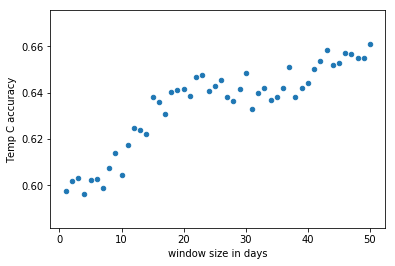

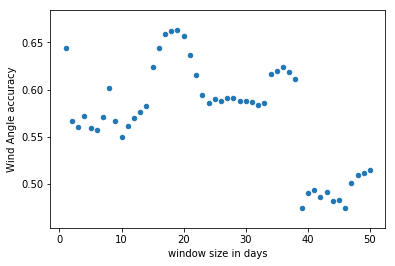

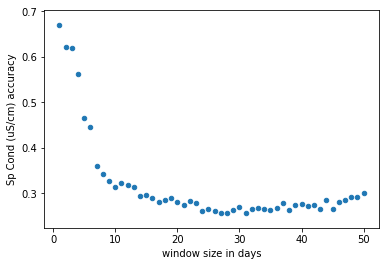

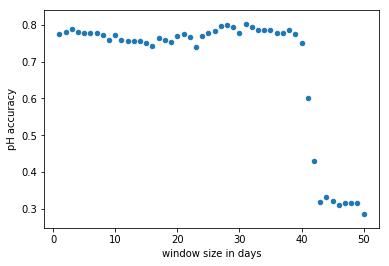

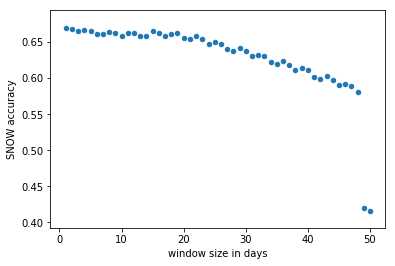

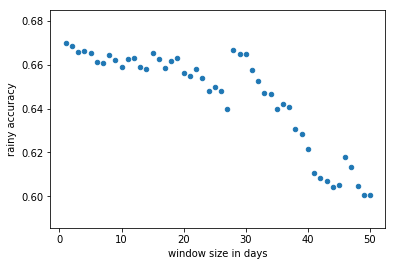

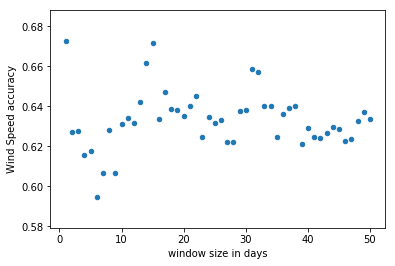

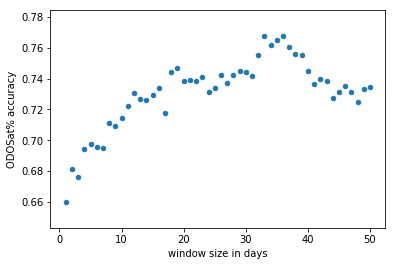

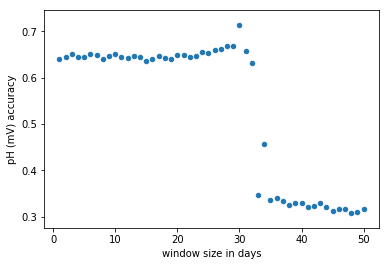

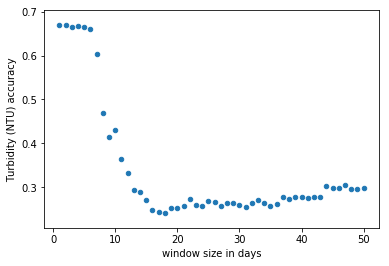

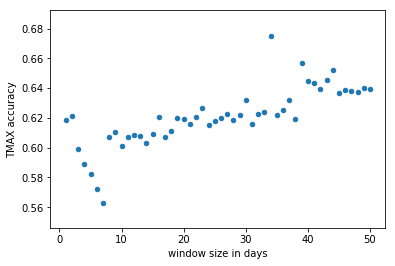

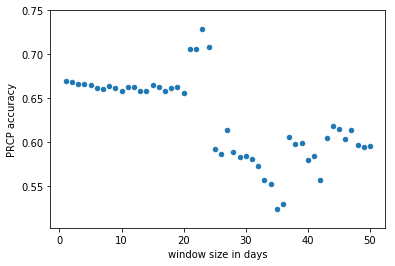

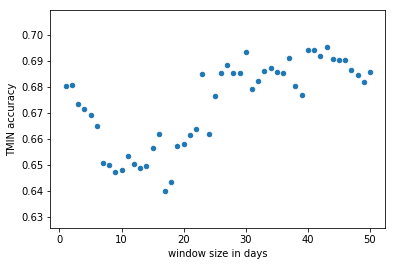

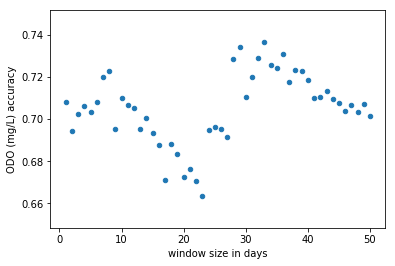

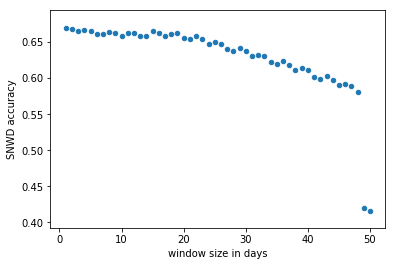

In [38]:
# Plot the accuracies vs window size for each column
sizes = [x.days for x in window_sizes]
for col in x_columns:
    df = pd.DataFrame({col + " accuracy": accuracies[col], 
                           "window size in days": sizes})
    df.plot(kind="scatter", y=col + " accuracy", x="window size in days")

## Greedy Custom Window Size
Create a greedy model using the best custom window sizes found above.

In [39]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

max_iter = 25000
loss = "log"

parameters = dict()
for col, x_win in best_x_windows.items():
    print(col, x_win)
    parameters[col] = {'x_win_size':x_win}

# Windowize
print("Windowizing 2017 data sets")
train = hf.windowize(train_dfs[0], 'datetime', 
                     target_column, custom_parameters=parameters)
for i in range(1, len(train_dfs)):
    train = train.append(hf.windowize(train_dfs[i], 'datetime', 
                         target_column, custom_parameters=parameters))
    print("Windowizing 2018 data sets")
test = hf.windowize(test_dfs[0], 'datetime', 
                    target_column, custom_parameters=parameters)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(test_dfs[i], 'datetime', 
                        target_column, custom_parameters=parameters))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Sort columns by accuracy
model = SGDClassifier(max_iter=max_iter, loss=loss)
sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                            test,
                                            x_columns,
                                            'bloom')
# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
    model, train, test, x_columns,'bloom', sorted_columns)
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()



Temp C 30 days 00:00:00
Wind Angle 19 days 00:00:00
Sp Cond (uS/cm) 1 days 00:00:00
pH 28 days 00:00:00
SNOW 1 days 00:00:00
rainy 1 days 00:00:00
Wind Speed 1 days 00:00:00
ODOSat% 19 days 00:00:00
pH (mV) 30 days 00:00:00
Turbidity (NTU) 1 days 00:00:00
TMAX 30 days 00:00:00
PRCP 23 days 00:00:00
TMIN 30 days 00:00:00
ODO (mg/L) 29 days 00:00:00
SNWD 1 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting featu

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6484947111472742
Recall: 0.6614349775784754
Precision 0.5121527777777778
Confusion Matrix:
 [[502 281]
 [151 295]]

Training model with: Wind Angle


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.5703824247355573
Recall: 0.1210762331838565
Precision 0.28421052631578947
Confusion Matrix:
 [[647 136]
 [392  54]]

Training model with: Sp Cond (uS/cm)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.28315703824247357
Recall: 0.1726457399103139
Precision 0.1307300509337861
Confusion Matrix:
 [[271 512]
 [369  77]]

Training model with: pH


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7762408462164361
Recall: 0.6995515695067265
Precision 0.6887417218543046
Confusion Matrix:
 [[642 141]
 [134 312]]

Training model with: SNOW


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Accuracy 0.6371033360455655
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[783   0]
 [446   0]]

Training model with: rainy


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6371033360455655
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[783   0]
 [446   0]]

Training model with: Wind Speed
Accuracy 0.5703824247355573
Recall: 0.28475336322869954
Precision 0.37797619047619047
Confusion Matrix:
 [[574 209]
 [319 127]]

Training model with: ODOSat%


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7070789259560618
Recall: 0.6188340807174888
Precision 0.592274678111588
Confusion Matrix:
 [[593 190]
 [170 276]]

Training model with: pH (mV)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7135882831570383
Recall: 0.8856502242152466
Precision 0.5675287356321839
Confusion Matrix:
 [[482 301]
 [ 51 395]]

Training model with: Turbidity (NTU)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.3124491456468674
Recall: 0.34080717488789236
Precision 0.21621621621621623
Confusion Matrix:
 [[232 551]
 [294 152]]

Training model with: TMAX


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6322213181448332
Recall: 0.7286995515695067
Precision 0.4954268292682927
Confusion Matrix:
 [[452 331]
 [121 325]]

Training model with: PRCP


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.5752644426362896
Recall: 0.5381165919282511
Precision 0.4316546762589928
Confusion Matrix:
 [[467 316]
 [206 240]]

Training model with: TMIN


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.6932465419039869
Recall: 0.8385650224215246
Precision 0.5508100147275405
Confusion Matrix:
 [[478 305]
 [ 72 374]]

Training model with: ODO (mg/L)


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Accuracy 0.7127746135069162
Recall: 0.531390134529148
Precision 0.6220472440944882
Confusion Matrix:
 [[639 144]
 [209 237]]

Training model with: SNWD


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 t

Accuracy 0.6371033360455655
Recall: 0.0
Precision 0.0
Confusion Matrix:
 [[783   0]
 [446   0]]

pH metric value: 0.7762408462164361
pH (mV) metric value: 0.7135882831570383
ODO (mg/L) metric value: 0.7127746135069162
ODOSat% metric value: 0.7070789259560618
TMIN metric value: 0.6932465419039869
Temp C metric value: 0.6484947111472742
SNOW metric value: 0.6371033360455655
rainy metric value: 0.6371033360455655
SNWD metric value: 0.6371033360455655
TMAX metric value: 0.6322213181448332
PRCP metric value: 0.5752644426362896
Wind Angle metric value: 0.5703824247355573
Wind Speed metric value: 0.5703824247355573
Turbidity (NTU) metric value: 0.3124491456468674
Sp Cond (uS/cm) metric value: 0.28315703824247357


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


base_columns: []
sorted_columns: ['pH', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'Temp C', 'SNOW', 'rainy', 'SNWD', 'TMAX', 'PRCP', 'Wind Angle', 'Wind Speed', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'pH (mV)', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'Temp C', 'SNOW', 'rainy', 'SNWD', 'TMAX', 'PRCP', 'Wind Angle', 'Wind Speed', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7762408462164361
Test model recall: 0.6995515695067265
Test model precision: 0.6887417218543046

Updating greedy model

Training model with: ['pH', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4483319772172498
Test model recall: 0.09192825112107623
Test model precision: 0.1305732484076433

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7347436940602116
Test model recall: 0.5672645739910314
Test model precision: 0.655440414507772

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7070789259560618
Test model recall: 0.6188340807174888
Test model precision: 0.592274678111588

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7957689178193653
Test model recall: 0.804932735426009
Test model precision: 0.6864244741873805

Updating greedy model

Training model with: ['pH', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8201790073230268
Test model recall: 0.8475336322869955
Test model precision: 0.711864406779661

Updating greedy model

Training model with: ['pH', 'TMIN', 'Temp C', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8193653376729048
Test model recall: 0.8452914798206278
Test model precision: 0.7113207547169811

Training model with: ['pH', 'TMIN', 'Temp C', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8177379983726607
Test model recall: 0.8452914798206278
Test model precision: 0.7086466165413534

Training model with: ['pH', 'TMIN', 'Temp C', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8193653376729048
Test model recall: 0.8452914798206278
Test model precision: 0.7113207547169811

Training model with: ['pH', 'TMIN', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8193653376729048
Test model recall: 0.8452914798206278
Test model precision: 0.7113207547169811

Training model with: ['pH', 'TMIN', 'Temp C', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7925142392188771
Test model recall: 0.7757847533632287
Test model precision: 0.6906187624750499

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8421480878763222
Test model recall: 0.9147982062780269
Test model precision: 0.723404255319149

Updating greedy model

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Angle', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8380797396257119
Test model recall: 0.9147982062780269
Test model precision: 0.7170474516695958

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Angle', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8380797396257119
Test model recall: 0.9170403587443946
Test model precision: 0.7162872154115587

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Angle', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.838893409275834
Test model recall: 0.9125560538116592
Test model precision: 0.7190812720848057

Final greedy columns: ['pH', 'TMIN', 'Temp C', 'Wind Angle']
Final greedy accuracy 0.8421480878763222
Final greedy recall: 0.9147982062780269
Final greedy precision: 0.723404255319149
Final greedy confusion matrix:
 [[627 156]
 [ 38 408]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6847826086956522
Test model recall: 0.4581673306772908
Test model precision: 0.7516339869281046
Final greedy confusion matrix:
 [[263  38]
 [136 115]]
accuracy 0.8421480878763222
recall 0.9147982062780269
precision 0.723404255319149



In [40]:
print("Cross validate:")
base_columns = ['TMIN', 'Temp C', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)']

print("test vs train:")
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom')
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)
print()

Cross validate:
test vs train:


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.7626811594202898
recall 0.5657370517928287
precision 0.8658536585365854



Performance of the model and the columns it selects seems to be largely dependent on the buey location.

## Greedy Window Size
Find a single optimal window size for all features

In [41]:
# add the weather columns to our x_columns
x_columns = list(set(x_columns + 
                     ['PRCP', 'SNOW', 'SNWD', 'TMAX', 'TMIN', 
                      'rainy', 'Wind Speed', 'Wind Angle']))

iteration_delta = pd.Timedelta(1, unit='d')
max_x_window = pd.Timedelta(30, unit='d') 
current_y_window = pd.Timedelta(1, unit='d')
best_accuracy = 0
best_recall = 0
best_precision = 0
best_x_window = iteration_delta
best_y_window = current_y_window

window_sizes = []
accuracies = []

max_iter = 25000
loss = "log"

current_x_window = current_y_window
while current_x_window <= max_x_window:

    # Windowize
    print("current x window", current_x_window)
    print("Windowizing 2017 data sets")
    train = hf.windowize(
        train_dfs[0], 'datetime', target_column, 
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(train_dfs)):
        train = train.append(hf.windowize(
            train_dfs[i], 'datetime', target_column, 
            x_win_size=current_x_window, y_win_size=current_y_window))
    print("Windowizing 2018 data sets")
    test = hf.windowize(
        test_dfs[0], 'datetime', target_column,
        x_win_size=current_x_window, y_win_size=current_y_window)
    for i in range(1, len(test_dfs)):
        test = test.append(hf.windowize(
            test_dfs[i], 'datetime', target_column,
            x_win_size=current_x_window, y_win_size=current_y_window))
    print()

    #Add rainy column
    for df in [test, train]:
        df['rainy'] = df['PRCP'].apply(
            lambda x: 1 if x > 0 else 0).astype('category')

    #Add target columns
    lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

    # Sort columns by accuracy
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    sorted_columns = lrf.sort_columns_by_metric(model, train, 
                                                test,
                                                x_columns,
                                                'bloom', verbose=0)
    # Create greedy model
    model = SGDClassifier(max_iter=max_iter, loss=loss)
    accuracy, recall, precision, cm, predictions, _, _ = lrf.greedy_model(
        model, train, test, x_columns,'bloom', sorted_columns )
    accuracies.append(accuracy)
    window_sizes.append(current_x_window)
    print("accuracy", accuracy)
    print("recall", recall)
    print("precision", precision)
    print()
    if accuracy > best_accuracy:
        print("Better Accuracy Found")
        best_accuracy = accuracy
        best_recall = recall
        best_precision = precision
        best_x_window = current_x_window
        best_y_window = current_y_window
    current_x_window += iteration_delta

current x window 1 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'Sp Cond (uS/cm)', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'TMAX', 'Temp C']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'TMIN', 'Wind Speed', 'Sp Cond (uS/cm)', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'ODOSat%', 'Wind Angle', 'pH (mV)', 'TMAX', 'Temp C']
Training model with: ['pH']
Test model accuracy: 0.7748478701825557
Test model recall: 0.7090163934426229
Test model precision: 0.6443202979515829

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8242055442866801
Test model recall: 0.7295081967213115
Test model precision: 0.7355371900826446

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8309668695064233
Test model recall: 0.7438524590163934
Test model precision: 0.7438524590163934

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8309668695064233
Test model recall: 0.7438524590163934
Test model precision: 0.7438524590163934

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8411088573360379
Test model recall: 0.7561475409836066
Test model precision: 0.7608247422680412

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8411088573360379
Test model recall: 0.7561475409836066
Test model precision: 0.7608247422680412

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8404327248140635
Test model recall: 0.7561475409836066
Test model precision: 0.7592592592592593

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397565922920892
Test model recall: 0.7540983606557377
Test model precision: 0.7587628865979381

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8424611223799865
Test model recall: 0.7602459016393442
Test model precision: 0.7618069815195072

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8424611223799865
Test model recall: 0.7602459016393442
Test model precision: 0.7618069815195072

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8451656524678837
Test model recall: 0.7663934426229508
Test model precision: 0.7648261758691206

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'ODOSat%', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397565922920892
Test model recall: 0.764344262295082
Test model precision: 0.7535353535353535

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'ODOSat%', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8248816768086545
Test model recall: 0.6598360655737705
Test model precision: 0.7759036144578313

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'ODOSat%', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8438133874239351
Test model recall: 0.7663934426229508
Test model precision: 0.7617107942973523

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'ODOSat%', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8417849898580122
Test model recall: 0.7704918032786885
Test model precision: 0.7550200803212851

Final greedy columns: ['pH', 'ODO (mg/L)', 'TMIN', 'Sp Cond (uS/cm)', 'PRCP', 'ODOSat%']
Final greedy accuracy 0.8451656524678837
Final greedy recall: 0.7663934426229508
Final greedy precision: 0.7648261758691206
Final greedy confusion matrix:
 [[876 115]
 [114 374]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7327188940092166
Test model recall: 0.4637096774193548
Test model precision: 0.7371794871794872
Final greedy confusion matrix:
 [[362  41]
 [133 115]]
accuracy 0.8451656524678837
recall 0.7663934426229508
precision 0.7648261758691206

Better Accuracy Found
current x window 2 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Sp Cond (uS/cm)', 'TMAX', 'Temp C', 'Wind Angle']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Sp Cond (uS/cm)', 'TMAX', 'Temp C', 'Wind Angle']
Training model with: ['pH']
Test model accuracy: 0.7814840027229408
Test model recall: 0.7166324435318275
Test model precision: 0.6560150375939849

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8339006126616746
Test model recall: 0.7351129363449692
Test model precision: 0.7568710359408034

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8298162014976175
Test model recall: 0.7515400410677618
Test model precision: 0.7393939393939394

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8386657590197413
Test model recall: 0.7638603696098563
Test model precision: 0.7530364372469636

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8386657590197413
Test model recall: 0.7638603696098563
Test model precision: 0.7530364372469636

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8352620830496936
Test model recall: 0.7679671457905544
Test model precision: 0.7435387673956262

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8400272294077604
Test model recall: 0.7720739219712526
Test model precision: 0.752

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8359428182437032
Test model recall: 0.7679671457905544
Test model precision: 0.7450199203187251

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8400272294077604
Test model recall: 0.7720739219712526
Test model precision: 0.752

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8352620830496936
Test model recall: 0.7351129363449692
Test model precision: 0.7600849256900213

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8413886997957795
Test model recall: 0.7741273100616016
Test model precision: 0.754

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8420694349897889
Test model recall: 0.7700205338809035
Test model precision: 0.7575757575757576

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Sp Cond (uS/cm)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8427501701837985
Test model recall: 0.7802874743326489
Test model precision: 0.753968253968254

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Sp Cond (uS/cm)', 'TMAX', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8434309053778081
Test model recall: 0.7823408624229979
Test model precision: 0.7544554455445545

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Sp Cond (uS/cm)', 'TMAX', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8515997277059224
Test model recall: 0.7926078028747433
Test model precision: 0.7673956262425448

Updating greedy model

Final greedy columns: ['pH', 'ODO (mg/L)', 'TMIN', 'Turbidity (NTU)', 'Wind Speed', 'Sp Cond (uS/cm)', 'TMAX', 'Temp C', 'Wind Angle']
Final greedy accuracy 0.8515997277059224
Final greedy recall: 0.7926078028747433
Final greedy precision: 0.7673956262425448
Final greedy confusion matrix:
 [[865 117]
 [101 386]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7685185185185185
Test model recall: 0.5810276679841897
Test model precision: 0.7696335078534031
Final greedy confusion matrix:
 [[351  44]
 [106 147]]
accuracy 0.8515997277059224
recall 0.7926078028747433
precision 0.7673956262425448

Better Accuracy Found
current x window 3 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Sp Cond (uS/cm)', 'Temp C', 'TMAX', 'Wind Angle']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Sp Cond (uS/cm)', 'Temp C', 'TMAX', 'Wind Angle']
Training model with: ['pH']
Test model accuracy: 0.7878165639972622
Test model recall: 0.7233606557377049
Test model precision: 0.6685606060606061

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8459958932238193
Test model recall: 0.7336065573770492
Test model precision: 0.7902869757174393

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8247775496235455
Test model recall: 0.7459016393442623
Test model precision: 0.7338709677419355

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8288843258042436
Test model recall: 0.7684426229508197
Test model precision: 0.732421875

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8459958932238193
Test model recall: 0.7336065573770492
Test model precision: 0.7902869757174393

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.837782340862423
Test model recall: 0.7377049180327869
Test model precision: 0.767590618336887

Training model with: ['pH', 'ODO (mg/L)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.839835728952772
Test model recall: 0.7397540983606558
Test model precision: 0.7713675213675214

Training model with: ['pH', 'ODO (mg/L)', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8459958932238193
Test model recall: 0.7336065573770492
Test model precision: 0.7902869757174393

Training model with: ['pH', 'ODO (mg/L)', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8459958932238193
Test model recall: 0.7336065573770492
Test model precision: 0.7902869757174393

Training model with: ['pH', 'ODO (mg/L)', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6837782340862423
Test model recall: 0.36065573770491804
Test model precision: 0.5398773006134969

Training model with: ['pH', 'ODO (mg/L)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8459958932238193
Test model recall: 0.7336065573770492
Test model precision: 0.7902869757174393

Training model with: ['pH', 'ODO (mg/L)', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.78507871321013
Test model recall: 0.6926229508196722
Test model precision: 0.6733067729083665

Training model with: ['pH', 'ODO (mg/L)', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8206707734428473
Test model recall: 0.7459016393442623
Test model precision: 0.7250996015936255

Training model with: ['pH', 'ODO (mg/L)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8343600273785079
Test model recall: 0.764344262295082
Test model precision: 0.746

Training model with: ['pH', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8425735797399042
Test model recall: 0.7315573770491803
Test model precision: 0.7828947368421053

Final greedy columns: ['pH', 'ODO (mg/L)']
Final greedy accuracy 0.8459958932238193
Final greedy recall: 0.7336065573770492
Final greedy precision: 0.7902869757174393
Final greedy confusion matrix:
 [[878  95]
 [130 358]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7872670807453416
Test model recall: 0.5141700404858299
Test model precision: 0.8819444444444444
Final greedy confusion matrix:
 [[380  17]
 [120 127]]
accuracy 0.8459958932238193
recall 0.7336065573770492
precision 0.7902869757174393

current x window 4 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7819807427785419
Test model recall: 0.7195876288659794
Test model precision: 0.6584905660377358

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397524071526823
Test model recall: 0.7360824742268042
Test model precision: 0.7727272727272727

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8101788170563962
Test model recall: 0.7237113402061855
Test model precision: 0.7119675456389453

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8239339752407153
Test model recall: 0.7525773195876289
Test model precision: 0.7285429141716567

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397524071526823
Test model recall: 0.7360824742268042
Test model precision: 0.7727272727272727

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397524071526823
Test model recall: 0.7360824742268042
Test model precision: 0.7727272727272727

Training model with: ['pH', 'ODO (mg/L)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8301237964236589
Test model recall: 0.7422680412371134
Test model precision: 0.7468879668049793

Training model with: ['pH', 'ODO (mg/L)', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8356258596973866
Test model recall: 0.7319587628865979
Test model precision: 0.7650862068965517

Training model with: ['pH', 'ODO (mg/L)', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397524071526823
Test model recall: 0.7360824742268042
Test model precision: 0.7727272727272727

Training model with: ['pH', 'ODO (mg/L)', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6121045392022009
Test model recall: 0.23505154639175257
Test model precision: 0.3713355048859935

Training model with: ['pH', 'ODO (mg/L)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8335625859697386
Test model recall: 0.7381443298969073
Test model precision: 0.7568710359408034

Training model with: ['pH', 'ODO (mg/L)', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8081155433287482
Test model recall: 0.7381443298969073
Test model precision: 0.7019607843137254

Training model with: ['pH', 'ODO (mg/L)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8239339752407153
Test model recall: 0.7628865979381443
Test model precision: 0.7240704500978473

Training model with: ['pH', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8349381017881705
Test model recall: 0.7360824742268042
Test model precision: 0.7611940298507462

Training model with: ['pH', 'ODO (mg/L)', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7620357634112792
Test model recall: 0.6927835051546392
Test model precision: 0.6303939962476548

Final greedy columns: ['pH', 'ODO (mg/L)']
Final greedy accuracy 0.8397524071526823
Final greedy recall: 0.7360824742268042
Final greedy precision: 0.7727272727272727
Final greedy confusion matrix:
 [[864 105]
 [128 357]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7784711388455539
Test model recall: 0.5140562248995983
Test model precision: 0.8590604026845637
Final greedy confusion matrix:
 [[371  21]
 [121 128]]
accuracy 0.8397524071526823
recall 0.7360824742268042
precision 0.7727272727272727

current x window 5 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.778393351800554
Test model recall: 0.7080745341614907
Test model precision: 0.6564299424184261

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8337950138504155
Test model recall: 0.7287784679089027
Test model precision: 0.7635574837310195

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8054016620498615
Test model recall: 0.7163561076604554
Test model precision: 0.7061224489795919

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8240997229916898
Test model recall: 0.7536231884057971
Test model precision: 0.7294589178356713

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8337950138504155
Test model recall: 0.7287784679089027
Test model precision: 0.7635574837310195

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8351800554016621
Test model recall: 0.7287784679089027
Test model precision: 0.7668845315904139

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.824792243767313
Test model recall: 0.7639751552795031
Test model precision: 0.7263779527559056

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.824792243767313
Test model recall: 0.7204968944099379
Test model precision: 0.7467811158798283

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8351800554016621
Test model recall: 0.7287784679089027
Test model precision: 0.7668845315904139

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5713296398891967
Test model recall: 0.15734989648033126
Test model precision: 0.2638888888888889

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8289473684210527
Test model recall: 0.7349896480331263
Test model precision: 0.7489451476793249

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8054016620498615
Test model recall: 0.7204968944099379
Test model precision: 0.7044534412955465

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8109418282548476
Test model recall: 0.7349896480331263
Test model precision: 0.71

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8275623268698061
Test model recall: 0.7391304347826086
Test model precision: 0.74375

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7146814404432132
Test model recall: 0.6335403726708074
Test model precision: 0.5656192236598891

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy']
Final greedy accuracy 0.8351800554016621
Final greedy recall: 0.7287784679089027
Final greedy precision: 0.7668845315904139
Final greedy confusion matrix:
 [[854 107]
 [131 352]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7789968652037618
Test model recall: 0.5241935483870968
Test model precision: 0.8496732026143791
Final greedy confusion matrix:
 [[367  23]
 [118 130]]
accuracy 0.8351800554016621
recall 0.7287784679089027
precision 0.7668845315904139

current x window 6 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'TMIN', 'SNOW', 'rainy', 'Turbidity (NTU)', 'PRCP', 'SNWD', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7777003484320557
Test model recall: 0.7139917695473251
Test model precision: 0.6584440227703985

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8306620209059233
Test model recall: 0.7160493827160493
Test model precision: 0.7682119205298014

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8069686411149826
Test model recall: 0.7181069958847737
Test model precision: 0.7137014314928425

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8160278745644599
Test model recall: 0.7386831275720165
Test model precision: 0.7237903225806451

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8306620209059233
Test model recall: 0.7160493827160493
Test model precision: 0.7682119205298014

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397212543554007
Test model recall: 0.7345679012345679
Test model precision: 0.7794759825327511

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8202090592334494
Test model recall: 0.742798353909465
Test model precision: 0.7307692307692307

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8355400696864111
Test model recall: 0.7181069958847737
Test model precision: 0.7790178571428571

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8397212543554007
Test model recall: 0.7345679012345679
Test model precision: 0.7794759825327511

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6006968641114983
Test model recall: 0.23251028806584362
Test model precision: 0.3610223642172524

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8104529616724738
Test model recall: 0.7407407407407407
Test model precision: 0.7114624505928854

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8355400696864111
Test model recall: 0.7304526748971193
Test model precision: 0.7717391304347826

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8167247386759582
Test model recall: 0.7407407407407407
Test model precision: 0.7243460764587525

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8369337979094077
Test model recall: 0.7325102880658436
Test model precision: 0.7739130434782608

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7212543554006968
Test model recall: 0.6502057613168725
Test model precision: 0.5787545787545788

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy']
Final greedy accuracy 0.8397212543554007
Final greedy recall: 0.7345679012345679
Final greedy precision: 0.7794759825327511
Final greedy confusion matrix:
 [[848 101]
 [129 357]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8012618296529969
Test model recall: 0.5934959349593496
Test model precision: 0.8488372093023255
Final greedy confusion matrix:
 [[362  26]
 [100 146]]
accuracy 0.8397212543554007
recall 0.7345679012345679
precision 0.7794759825327511

current x window 7 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Turbidity (NTU)', 'Temp C', 'Wind Angle', 'TMAX', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Turbidity (NTU)', 'Temp C', 'Wind Angle', 'TMAX', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7791023842917251
Test model recall: 0.6983471074380165
Test model precision: 0.6666666666666666

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.835203366058906
Test model recall: 0.7024793388429752
Test model precision: 0.7888631090487239

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7980364656381487
Test model recall: 0.6921487603305785
Test model precision: 0.7067510548523207

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.835203366058906
Test model recall: 0.7024793388429752
Test model precision: 0.7888631090487239

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8408134642356241
Test model recall: 0.7231404958677686
Test model precision: 0.7900677200902935

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8464235624123422
Test model recall: 0.7293388429752066
Test model precision: 0.800453514739229

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8478260869565217
Test model recall: 0.7293388429752066
Test model precision: 0.8041002277904328

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8162692847124825
Test model recall: 0.75
Test model precision: 0.7202380952380952

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6458625525946704
Test model recall: 0.30165289256198347
Test model precision: 0.46645367412140576

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8436185133239832
Test model recall: 0.7334710743801653
Test model precision: 0.7906458797327395

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8162692847124825
Test model recall: 0.731404958677686
Test model precision: 0.7283950617283951

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8120617110799438
Test model recall: 0.7396694214876033
Test model precision: 0.716

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8492286115007013
Test model recall: 0.731404958677686
Test model precision: 0.806378132118451

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Wind Angle', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8267882187938289
Test model recall: 0.7355371900826446
Test model precision: 0.7494736842105263

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Wind Angle', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.711781206171108
Test model recall: 0.6466942148760331
Test model precision: 0.566003616636528

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD', 'Wind Angle']
Final greedy accuracy 0.8492286115007013
Final greedy recall: 0.731404958677686
Final greedy precision: 0.806378132118451
Final greedy confusion matrix:
 [[857  85]
 [130 354]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7828843106180665
Test model recall: 0.5870445344129555
Test model precision: 0.8055555555555556
Final greedy confusion matrix:
 [[349  35]
 [102 145]]
accuracy 0.8492286115007013
recall 0.731404958677686
precision 0.806378132118451

current x window 8 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Seg

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODO (mg/L)', 'ODOSat%', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.773784355179704
Test model recall: 0.6974789915966386
Test model precision: 0.6522593320235757

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8414376321353065
Test model recall: 0.7121848739495799
Test model precision: 0.7939110070257611

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7928118393234672
Test model recall: 0.6911764705882353
Test model precision: 0.6911764705882353

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8414376321353065
Test model recall: 0.7121848739495799
Test model precision: 0.7939110070257611

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8449612403100775
Test model recall: 0.7205882352941176
Test model precision: 0.7976744186046512

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8372093023255814
Test model recall: 0.7331932773109243
Test model precision: 0.7704194260485652

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8449612403100775
Test model recall: 0.7205882352941176
Test model precision: 0.7976744186046512

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8153629316420014
Test model recall: 0.7226890756302521
Test model precision: 0.7257383966244726

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.5574348132487668
Test model recall: 0.14915966386554622
Test model precision: 0.24149659863945577

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8372093023255814
Test model recall: 0.7184873949579832
Test model precision: 0.7790432801822323

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8076109936575053
Test model recall: 0.707983193277311
Test model precision: 0.7154989384288747

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.813953488372093
Test model recall: 0.7331932773109243
Test model precision: 0.7181069958847737

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8400281888653982
Test model recall: 0.7184873949579832
Test model precision: 0.7862068965517242

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8097251585623678
Test model recall: 0.7310924369747899
Test model precision: 0.710204081632653

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6610288935870331
Test model recall: 0.5861344537815126
Test model precision: 0.4955595026642984

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy']
Final greedy accuracy 0.8449612403100775
Final greedy recall: 0.7205882352941176
Final greedy precision: 0.7976744186046512
Final greedy confusion matrix:
 [[856  87]
 [133 343]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.784688995215311
Test model recall: 0.5524193548387096
Test model precision: 0.8509316770186336
Final greedy confusion matrix:
 [[355  24]
 [111 137]]
accuracy 0.8449612403100775
recall 0.7205882352941176
precision 0.7976744186046512

current x window 9 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Se

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Speed', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.758694109297374
Test model recall: 0.7016806722689075
Test model precision: 0.6278195488721805

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7906316536550745
Test model recall: 0.7142857142857143
Test model precision: 0.6813627254509018

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7792760823278921
Test model recall: 0.707983193277311
Test model precision: 0.6620825147347741

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7906316536550745
Test model recall: 0.7142857142857143
Test model precision: 0.6813627254509018

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8019872249822569
Test model recall: 0.7184873949579832
Test model precision: 0.702258726899384

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8176011355571328
Test model recall: 0.75
Test model precision: 0.7212121212121212

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8176011355571328
Test model recall: 0.75
Test model precision: 0.7212121212121212

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8161816891412349
Test model recall: 0.7457983193277311
Test model precision: 0.7200811359026369

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8190205819730305
Test model recall: 0.8004201680672269
Test model precision: 0.7042513863216266

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8069552874378992
Test model recall: 0.7436974789915967
Test model precision: 0.7023809523809523

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8055358410220014
Test model recall: 0.7331932773109243
Test model precision: 0.7036290322580645

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8339247693399574
Test model recall: 0.8046218487394958
Test model precision: 0.7309160305343512

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Speed', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8055358410220014
Test model recall: 0.7100840336134454
Test model precision: 0.7130801687763713

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Speed', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8275372604684174
Test model recall: 0.7983193277310925
Test model precision: 0.7210626185958254

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Speed', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.837473385379702
Test model recall: 0.7983193277310925
Test model precision: 0.7407407407407407

Updating greedy model

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Speed', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.837473385379702
Final greedy recall: 0.7983193277310925
Final greedy precision: 0.7407407407407407
Final greedy confusion matrix:
 [[800 133]
 [ 96 380]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7019230769230769
Test model recall: 0.31620553359683795
Test model precision: 0.8602150537634409
Final greedy confusion matrix:
 [[358  13]
 [173  80]]
accuracy 0.837473385379702
recall 0.7983193277310925
precision 0.7407407407407407

current x window 10 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'pH (mV)', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'pH (mV)', 'TMIN', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7730192719486081
Test model recall: 0.7175732217573222
Test model precision: 0.6520912547528517

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.76802284082798
Test model recall: 0.6736401673640168
Test model precision: 0.6558044806517311

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8222698072805139
Test model recall: 0.7196652719665272
Test model precision: 0.7494553376906318

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8222698072805139
Test model recall: 0.7196652719665272
Test model precision: 0.7494553376906318

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8386866523911491
Test model recall: 0.7238493723849372
Test model precision: 0.7863636363636364

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8472519628836546
Test model recall: 0.7364016736401674
Test model precision: 0.8

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8472519628836546
Test model recall: 0.7364016736401674
Test model precision: 0.8

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7730192719486081
Test model recall: 0.6255230125523012
Test model precision: 0.682648401826484

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8187009279086367
Test model recall: 0.7447698744769874
Test model precision: 0.7295081967213115

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8443968593861527
Test model recall: 0.7384937238493724
Test model precision: 0.7914798206278026

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8179871520342612
Test model recall: 0.7468619246861925
Test model precision: 0.7270875763747454

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8301213418986438
Test model recall: 0.7447698744769874
Test model precision: 0.7542372881355932

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8472519628836546
Test model recall: 0.7364016736401674
Test model precision: 0.8

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8229835831548894
Test model recall: 0.7343096234309623
Test model precision: 0.7436440677966102

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.729478943611706
Test model recall: 0.696652719665272
Test model precision: 0.5873015873015873

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']
Final greedy accuracy 0.8472519628836546
Final greedy recall: 0.7364016736401674
Final greedy precision: 0.8
Final greedy confusion matrix:
 [[835  88]
 [126 352]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.785483870967742
Test model recall: 0.5668016194331984
Test model precision: 0.8433734939759037
Final greedy confusion matrix:
 [[347  26]
 [107 140]]
accuracy 0.8472519628836546
recall 0.7364016736401674
precision 0.8

current x window 11 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Ex

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7604017216642754
Test model recall: 0.7063829787234043
Test model precision: 0.6287878787878788

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7754662840746055
Test model recall: 0.6851063829787234
Test model precision: 0.6611909650924025

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7740315638450502
Test model recall: 0.6914893617021277
Test model precision: 0.6565656565656566

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7754662840746055
Test model recall: 0.6851063829787234
Test model precision: 0.6611909650924025

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7898134863701578
Test model recall: 0.7127659574468085
Test model precision: 0.6795131845841785

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8142037302725968
Test model recall: 0.7148936170212766
Test model precision: 0.7288503253796096

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8142037302725968
Test model recall: 0.7148936170212766
Test model precision: 0.7288503253796096

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8142037302725968
Test model recall: 0.7148936170212766
Test model precision: 0.7288503253796096

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8192252510760402
Test model recall: 0.8276595744680851
Test model precision: 0.6946428571428571

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8192252510760402
Test model recall: 0.8276595744680851
Test model precision: 0.6946428571428571

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8185078909612625
Test model recall: 0.8148936170212766
Test model precision: 0.697632058287796

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8077474892395983
Test model recall: 0.7936170212765957
Test model precision: 0.6856617647058824

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8199426111908178
Test model recall: 0.7936170212765957
Test model precision: 0.7077798861480076

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Angle', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.812051649928264
Test model recall: 0.8
Test model precision: 0.6911764705882353

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Angle', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7948350071736011
Test model recall: 0.825531914893617
Test model precision: 0.6554054054054054

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)', 'Wind Angle']
Final greedy accuracy 0.8199426111908178
Final greedy recall: 0.7936170212765957
Final greedy precision: 0.7077798861480076
Final greedy confusion matrix:
 [[770 154]
 [ 97 373]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7990275526742301
Test model recall: 0.5823293172690763
Test model precision: 0.8787878787878788
Final greedy confusion matrix:
 [[348  20]
 [104 145]]
accuracy 0.8199426111908178
recall 0.7936170212765957
precision 0.7077798861480076

current x window 12 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7572254335260116
Test model recall: 0.6931330472103004
Test model precision: 0.625968992248062

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7803468208092486
Test model recall: 0.6716738197424893
Test model precision: 0.6745689655172413

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7608381502890174
Test model recall: 0.6630901287553648
Test model precision: 0.639751552795031

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7803468208092486
Test model recall: 0.6716738197424893
Test model precision: 0.6745689655172413

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7839595375722543
Test model recall: 0.6995708154506438
Test model precision: 0.6721649484536083

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8186416184971098
Test model recall: 0.6974248927038627
Test model precision: 0.7471264367816092

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8186416184971098
Test model recall: 0.6974248927038627
Test model precision: 0.7471264367816092

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8215317919075145
Test model recall: 0.7060085836909872
Test model precision: 0.7494305239179955

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7955202312138728
Test model recall: 0.8326180257510729
Test model precision: 0.654300168634064

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8208092485549133
Test model recall: 0.7060085836909872
Test model precision: 0.7477272727272727

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8222543352601156
Test model recall: 0.7253218884120172
Test model precision: 0.7412280701754386

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.819364161849711
Test model recall: 0.7145922746781116
Test model precision: 0.74

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.815028901734104
Test model recall: 0.759656652360515
Test model precision: 0.7108433734939759

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8244219653179191
Test model recall: 0.7339055793991416
Test model precision: 0.7418655097613883

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7413294797687862
Test model recall: 0.721030042918455
Test model precision: 0.5957446808510638

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Turbidity (NTU)']
Final greedy accuracy 0.8244219653179191
Final greedy recall: 0.7339055793991416
Final greedy precision: 0.7418655097613883
Final greedy confusion matrix:
 [[799 119]
 [124 342]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.760586319218241
Test model recall: 0.6153846153846154
Test model precision: 0.7450980392156863
Final greedy confusion matrix:
 [[315  52]
 [ 95 152]]
accuracy 0.8244219653179191
recall 0.7339055793991416
precision 0.7418655097613883

current x window 13 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Wind Speed', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.757090909090909
Test model recall: 0.7014925373134329
Test model precision: 0.6290630975143403

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7847272727272727
Test model recall: 0.6908315565031983
Test model precision: 0.6821052631578948

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.765090909090909
Test model recall: 0.6801705756929638
Test model precision: 0.6483739837398373

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7847272727272727
Test model recall: 0.6908315565031983
Test model precision: 0.6821052631578948

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8138181818181818
Test model recall: 0.7164179104477612
Test model precision: 0.7320261437908496

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.824
Test model recall: 0.7100213219616205
Test model precision: 0.7585421412300684

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8247272727272728
Test model recall: 0.7121535181236673
Test model precision: 0.759090909090909

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8254545454545454
Test model recall: 0.7142857142857143
Test model precision: 0.7596371882086168

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7192727272727273
Test model recall: 0.8976545842217484
Test model precision: 0.5546772068511199

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8145454545454546
Test model recall: 0.7100213219616205
Test model precision: 0.7367256637168141

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8269090909090909
Test model recall: 0.7164179104477612
Test model precision: 0.7619047619047619

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8261818181818181
Test model recall: 0.7121535181236673
Test model precision: 0.7625570776255708

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.832
Test model recall: 0.7633262260127932
Test model precision: 0.7489539748953975

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'Wind Angle', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8152727272727273
Test model recall: 0.7398720682302772
Test model precision: 0.7244258872651357

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'Wind Angle', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8
Test model recall: 0.720682302771855
Test model precision: 0.7012448132780082

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'Wind Angle']
Final greedy accuracy 0.832
Final greedy recall: 0.7633262260127932
Final greedy precision: 0.7489539748953975
Final greedy confusion matrix:
 [[786 120]
 [111 358]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7950819672131147
Test model recall: 0.6475409836065574
Test model precision: 0.8020304568527918
Final greedy confusion matrix:
 [[327  39]
 [ 86 158]]
accuracy 0.832
recall 0.7633262260127932
precision 0.7489539748953975

current x window 14 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7569546120058566
Test model recall: 0.7066381156316917
Test model precision: 0.6285714285714286

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7723279648609077
Test model recall: 0.6745182012847966
Test model precision: 0.6645569620253164

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.746705710102489
Test model recall: 0.6488222698072805
Test model precision: 0.6247422680412371

Training model with: ['pH', 'ODOSat%', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7415812591508053
Test model recall: 0.6552462526766595
Test model precision: 0.6144578313253012

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7723279648609077
Test model recall: 0.6745182012847966
Test model precision: 0.6645569620253164

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7884333821376281
Test model recall: 0.7130620985010707
Test model precision: 0.6823770491803278

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8177159590043924
Test model recall: 0.715203426124197
Test model precision: 0.7422222222222222

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8177159590043924
Test model recall: 0.715203426124197
Test model precision: 0.7422222222222222

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8177159590043924
Test model recall: 0.715203426124197
Test model precision: 0.7422222222222222

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7562225475841874
Test model recall: 0.8843683083511777
Test model precision: 0.596820809248555

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8118594436310396
Test model recall: 0.7130620985010707
Test model precision: 0.7302631578947368

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8060029282576867
Test model recall: 0.7130620985010707
Test model precision: 0.7176724137931034

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8118594436310396
Test model recall: 0.7537473233404711
Test model precision: 0.7125506072874493

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8169838945827232
Test model recall: 0.715203426124197
Test model precision: 0.7405764966740577

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8177159590043924
Test model recall: 0.7194860813704497
Test model precision: 0.7400881057268722

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP']
Final greedy accuracy 0.8177159590043924
Final greedy recall: 0.715203426124197
Final greedy precision: 0.7422222222222222
Final greedy confusion matrix:
 [[783 116]
 [133 334]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7841845140032949
Test model recall: 0.6382113821138211
Test model precision: 0.7889447236180904
Final greedy confusion matrix:
 [[319  42]
 [ 89 157]]
accuracy 0.8177159590043924
recall 0.715203426124197
precision 0.7422222222222222

current x window 15 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'pH (mV)', 'Wind Angle', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Speed', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'pH (mV)', 'Wind Angle', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7512877115526122
Test model recall: 0.7054945054945055
Test model precision: 0.6114285714285714

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7807211184694628
Test model recall: 0.701098901098901
Test model precision: 0.6632016632016632

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.775570272259014
Test model recall: 0.6857142857142857
Test model precision: 0.6582278481012658

Training model with: ['pH', 'ODOSat%', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7512877115526122
Test model recall: 0.676923076923077
Test model precision: 0.6172344689378757

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7807211184694628
Test model recall: 0.701098901098901
Test model precision: 0.6632016632016632

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8175128771155261
Test model recall: 0.7318681318681318
Test model precision: 0.7254901960784313

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8307579102281089
Test model recall: 0.7252747252747253
Test model precision: 0.7586206896551724

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8307579102281089
Test model recall: 0.7252747252747253
Test model precision: 0.7586206896551724

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8351729212656365
Test model recall: 0.7318681318681318
Test model precision: 0.7655172413793103

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8381162619573216
Test model recall: 0.7230769230769231
Test model precision: 0.7777777777777778

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7557027225901398
Test model recall: 0.8527472527472527
Test model precision: 0.5941807044410413

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8292862398822664
Test model recall: 0.7736263736263737
Test model precision: 0.7318087318087318

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8381162619573216
Test model recall: 0.7252747252747253
Test model precision: 0.7764705882352941

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8123620309050773
Test model recall: 0.7032967032967034
Test model precision: 0.7272727272727273

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.811626195732156
Test model recall: 0.734065934065934
Test model precision: 0.7121535181236673

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C']
Final greedy accuracy 0.8381162619573216
Final greedy recall: 0.7230769230769231
Final greedy precision: 0.7777777777777778
Final greedy confusion matrix:
 [[810  94]
 [126 329]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7661691542288557
Test model recall: 0.6138211382113821
Test model precision: 0.766497461928934
Final greedy confusion matrix:
 [[311  46]
 [ 95 151]]
accuracy 0.8381162619573216
recall 0.7230769230769231
precision 0.7777777777777778

current x window 16 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Wind Angle', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Wind Angle', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.742772424017791
Test model recall: 0.7032967032967034
Test model precision: 0.6015037593984962

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7857672349888807
Test model recall: 0.7208791208791209
Test model precision: 0.6693877551020408

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7501853224610823
Test model recall: 0.6703296703296703
Test model precision: 0.6199186991869918

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7857672349888807
Test model recall: 0.7208791208791209
Test model precision: 0.6693877551020408

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8146775389177169
Test model recall: 0.7362637362637363
Test model precision: 0.7204301075268817

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8346923647146034
Test model recall: 0.7450549450549451
Test model precision: 0.7600896860986547

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8346923647146034
Test model recall: 0.7450549450549451
Test model precision: 0.7600896860986547

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8339510748702743
Test model recall: 0.7472527472527473
Test model precision: 0.7572383073496659

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8265381764269829
Test model recall: 0.7758241758241758
Test model precision: 0.7278350515463917

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7783543365455893
Test model recall: 0.8615384615384616
Test model precision: 0.6242038216560509

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8191252779836916
Test model recall: 0.734065934065934
Test model precision: 0.7308533916849015

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.815418828762046
Test model recall: 0.7384615384615385
Test model precision: 0.721030042918455

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8354336545589326
Test model recall: 0.7450549450549451
Test model precision: 0.7617977528089888

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMAX', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8369162342475908
Test model recall: 0.7450549450549451
Test model precision: 0.7652370203160271

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8013343217197925
Test model recall: 0.7516483516483516
Test model precision: 0.6881287726358148

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMAX', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.8369162342475908
Final greedy recall: 0.7450549450549451
Final greedy precision: 0.7652370203160271
Final greedy confusion matrix:
 [[790 104]
 [116 339]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7783333333333333
Test model recall: 0.5697211155378487
Test model precision: 0.8511904761904762
Final greedy confusion matrix:
 [[324  25]
 [108 143]]
accuracy 0.8369162342475908
recall 0.7450549450549451
precision 0.7652370203160271

current x window 17 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pred

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'Wind Speed', 'pH (mV)', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'Wind Speed', 'pH (mV)', 'TMIN', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7651006711409396
Test model recall: 0.7074235807860262
Test model precision: 0.6415841584158416

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7494407158836689
Test model recall: 0.62882096069869
Test model precision: 0.6343612334801763

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7829977628635347
Test model recall: 0.6266375545851528
Test model precision: 0.7051597051597052

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7636092468307233
Test model recall: 0.6179039301310044
Test model precision: 0.6658823529411765

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7829977628635347
Test model recall: 0.6266375545851528
Test model precision: 0.7051597051597052

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8202833706189411
Test model recall: 0.6855895196506551
Test model precision: 0.7639902676399026

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8292319164802386
Test model recall: 0.7117903930131004
Test model precision: 0.7706855791962175

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8292319164802386
Test model recall: 0.7117903930131004
Test model precision: 0.7706855791962175

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8314690529455631
Test model recall: 0.7292576419213974
Test model precision: 0.7660550458715596

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8240119313944817
Test model recall: 0.7030567685589519
Test model precision: 0.7630331753554502

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8061148396718867
Test model recall: 0.7489082969432315
Test model precision: 0.7028688524590164

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7912005965697241
Test model recall: 0.7379912663755459
Test model precision: 0.678714859437751

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8068605518269948
Test model recall: 0.74235807860262
Test model precision: 0.7068607068607069

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6942580164056674
Test model recall: 0.6244541484716157
Test model precision: 0.5458015267175572

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8031319910514542
Test model recall: 0.7532751091703057
Test model precision: 0.6955645161290323

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'Wind Speed']
Final greedy accuracy 0.8314690529455631
Final greedy recall: 0.7292576419213974
Final greedy precision: 0.7660550458715596
Final greedy confusion matrix:
 [[781 102]
 [124 334]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7248322147651006
Test model recall: 0.4959349593495935
Test model precision: 0.7530864197530864
Final greedy confusion matrix:
 [[310  40]
 [124 122]]
accuracy 0.8314690529455631
recall 0.7292576419213974
precision 0.7660550458715596

current x window 18 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pred

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7586206896551724
Test model recall: 0.7028824833702882
Test model precision: 0.6277227722772277

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7563718140929535
Test model recall: 0.6541019955654102
Test model precision: 0.6357758620689655

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8140929535232384
Test model recall: 0.6585365853658537
Test model precision: 0.7595907928388747

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7653673163418291
Test model recall: 0.6274944567627494
Test model precision: 0.6612149532710281

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8140929535232384
Test model recall: 0.6585365853658537
Test model precision: 0.7595907928388747

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.823088455772114
Test model recall: 0.7184035476718403
Test model precision: 0.7482678983833718

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.828335832083958
Test model recall: 0.7095343680709535
Test model precision: 0.7655502392344498

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.828335832083958
Test model recall: 0.7095343680709535
Test model precision: 0.7655502392344498

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.841079460269865
Test model recall: 0.7450110864745011
Test model precision: 0.7759815242494227

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.719640179910045
Test model recall: 0.8980044345898004
Test model precision: 0.5525238744884038

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.841079460269865
Test model recall: 0.7450110864745011
Test model precision: 0.7759815242494227

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.828335832083958
Test model recall: 0.7560975609756098
Test model precision: 0.741304347826087

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8440779610194903
Test model recall: 0.7560975609756098
Test model precision: 0.7767653758542141

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'TMAX', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8530734632683659
Test model recall: 0.7671840354767184
Test model precision: 0.7917620137299771

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8373313343328336
Test model recall: 0.7827050997782705
Test model precision: 0.7478813559322034

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP', 'TMIN', 'TMAX', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.8530734632683659
Final greedy recall: 0.7671840354767184
Final greedy precision: 0.7917620137299771
Final greedy confusion matrix:
 [[792  91]
 [105 346]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7554806070826307
Test model recall: 0.48582995951417
Test model precision: 0.8695652173913043
Final greedy confusion matrix:
 [[328  18]
 [127 120]]
accuracy 0.8530734632683659
recall 0.7671840354767184
precision 0.7917620137299771

Better Accuracy Found
current x window 19 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combi

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pred

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'TMIN', 'Temp C', 'pH (mV)', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7530211480362538
Test model recall: 0.7040358744394619
Test model precision: 0.6168958742632613

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7552870090634441
Test model recall: 0.6412556053811659
Test model precision: 0.6355555555555555

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7552870090634441
Test model recall: 0.6412556053811659
Test model precision: 0.6355555555555555

Training model with: ['pH', 'ODOSat%', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7356495468277946
Test model recall: 0.6188340807174888
Test model precision: 0.6052631578947368

Training model with: ['pH', 'ODOSat%', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7552870090634441
Test model recall: 0.6412556053811659
Test model precision: 0.6355555555555555

Training model with: ['pH', 'ODOSat%', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8293051359516617
Test model recall: 0.7354260089686099
Test model precision: 0.7522935779816514

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8398791540785498
Test model recall: 0.742152466367713
Test model precision: 0.7733644859813084

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8398791540785498
Test model recall: 0.742152466367713
Test model precision: 0.7733644859813084

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8406344410876133
Test model recall: 0.7354260089686099
Test model precision: 0.7790973871733967

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8391238670694864
Test model recall: 0.7309417040358744
Test model precision: 0.7780429594272077

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7605740181268882
Test model recall: 0.8542600896860987
Test model precision: 0.6018957345971564

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8429003021148036
Test model recall: 0.742152466367713
Test model precision: 0.7806603773584906

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Wind Speed', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8421450151057401
Test model recall: 0.757847533632287
Test model precision: 0.7699316628701595

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Wind Speed', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8549848942598187
Test model recall: 0.7600896860986547
Test model precision: 0.7995283018867925

Updating greedy model

Training model with: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Wind Speed', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8527190332326284
Test model recall: 0.7825112107623319
Test model precision: 0.7807606263982103

Final greedy columns: ['pH', 'ODOSat%', 'rainy', 'PRCP', 'TMIN', 'Wind Speed', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.8549848942598187
Final greedy recall: 0.7600896860986547
Final greedy precision: 0.7995283018867925
Final greedy confusion matrix:
 [[793  85]
 [107 339]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6966101694915254
Test model recall: 0.47560975609756095
Test model precision: 0.7005988023952096
Final greedy confusion matrix:
 [[294  50]
 [129 117]]
accuracy 0.8549848942598187
recall 0.7600896860986547
precision 0.7995283018867925

Better Accuracy Found
current x window 20 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Co

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pred

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'Wind Angle', 'SNOW', 'rainy', 'PRCP', 'SNWD', 'pH (mV)', 'Temp C', 'Wind Speed', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7711026615969582
Test model recall: 0.7035398230088495
Test model precision: 0.6556701030927835

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7566539923954373
Test model recall: 0.6261061946902655
Test model precision: 0.652073732718894

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8045627376425856
Test model recall: 0.6438053097345132
Test model precision: 0.751937984496124

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7832699619771863
Test model recall: 0.7057522123893806
Test model precision: 0.6772823779193206

Training model with: ['pH', 'ODO (mg/L)', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7513307984790875
Test model recall: 0.6238938053097345
Test model precision: 0.642369020501139

Training model with: ['pH', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8045627376425856
Test model recall: 0.6438053097345132
Test model precision: 0.751937984496124

Training model with: ['pH', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8372623574144487
Test model recall: 0.7146017699115044
Test model precision: 0.7916666666666666

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8258555133079848
Test model recall: 0.6946902654867256
Test model precision: 0.7753086419753087

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8372623574144487
Test model recall: 0.7146017699115044
Test model precision: 0.7916666666666666

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6844106463878327
Test model recall: 0.40486725663716816
Test model precision: 0.5562310030395137

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8395437262357415
Test model recall: 0.75
Test model precision: 0.7757437070938215

Updating greedy model

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8053231939163498
Test model recall: 0.75
Test model precision: 0.7033195020746889

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8273764258555133
Test model recall: 0.75
Test model precision: 0.7483443708609272

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8121673003802281
Test model recall: 0.7345132743362832
Test model precision: 0.7233115468409586

Training model with: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7680608365019012
Test model recall: 0.7986725663716814
Test model precision: 0.6278260869565218

Final greedy columns: ['pH', 'ODO (mg/L)', 'rainy', 'Temp C']
Final greedy accuracy 0.8395437262357415
Final greedy recall: 0.75
Final greedy precision: 0.7757437070938215
Final greedy confusion matrix:
 [[765  98]
 [113 339]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7457337883959044
Test model recall: 0.6311475409836066
Test model precision: 0.7230046948356808
Final greedy confusion matrix:
 [[283  59]
 [ 90 154]]
accuracy 0.8395437262357415
recall 0.75
precision 0.7757437070938215

current x window 21 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'PRCP', 'ODO (mg/L)', 'TMIN', 'SNOW', 'rainy', 'SNWD', 'pH (mV)', 'Wind Speed', 'Temp C', 'Wind Angle', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'PRCP', 'ODO (mg/L)', 'TMIN', 'SNOW', 'rainy', 'SNWD', 'pH (mV)', 'Wind Speed', 'Temp C', 'Wind Angle', 'TMAX', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7741194486983155
Test model recall: 0.7095343680709535
Test model precision: 0.6611570247933884

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7411944869831547
Test model recall: 0.5986696230598669
Test model precision: 0.6323185011709602

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7924961715160797
Test model recall: 0.70509977827051
Test model precision: 0.6973684210526315

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.821592649310873
Test model recall: 0.70509977827051
Test model precision: 0.7607655502392344

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8124042879019908
Test model recall: 0.7605321507760532
Test model precision: 0.7145833333333333

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.821592649310873
Test model recall: 0.70509977827051
Test model precision: 0.7607655502392344

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8269525267993875
Test model recall: 0.7006651884700665
Test model precision: 0.7764127764127764

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8269525267993875
Test model recall: 0.7006651884700665
Test model precision: 0.7764127764127764

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6814701378254211
Test model recall: 0.4567627494456763
Test model precision: 0.5464190981432361

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8269525267993875
Test model recall: 0.7006651884700665
Test model precision: 0.7764127764127764

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8192955589586524
Test model recall: 0.7139689578713969
Test model precision: 0.7505827505827506

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8055130168453293
Test model recall: 0.753880266075388
Test model precision: 0.7039337474120083

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.821592649310873
Test model recall: 0.729490022172949
Test model precision: 0.7477272727272727

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7182235834609495
Test model recall: 0.6430155210643016
Test model precision: 0.5835010060362174

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7901990811638591
Test model recall: 0.7472283813747228
Test model precision: 0.6780684104627767

Final greedy columns: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy']
Final greedy accuracy 0.8269525267993875
Final greedy recall: 0.7006651884700665
Final greedy precision: 0.7764127764127764
Final greedy confusion matrix:
 [[764  91]
 [135 316]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7152658662092625
Test model recall: 0.4024390243902439
Test model precision: 0.8389830508474576
Final greedy confusion matrix:
 [[318  19]
 [147  99]]
accuracy 0.8269525267993875
recall 0.7006651884700665
precision 0.7764127764127764

current x window 22 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'PRCP', 'ODO (mg/L)', 'TMIN', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'PRCP', 'ODO (mg/L)', 'TMIN', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'pH (mV)', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7659738260200154
Test model recall: 0.7072072072072072
Test model precision: 0.6434426229508197

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7498075442648191
Test model recall: 0.5900900900900901
Test model precision: 0.6469135802469136

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.789838337182448
Test model recall: 0.7027027027027027
Test model precision: 0.6887417218543046

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8221709006928406
Test model recall: 0.6936936936936937
Test model precision: 0.7642679900744417

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8021555042340262
Test model recall: 0.7545045045045045
Test model precision: 0.6935817805383023

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8221709006928406
Test model recall: 0.6936936936936937
Test model precision: 0.7642679900744417

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8252501924557352
Test model recall: 0.6981981981981982
Test model precision: 0.7692307692307693

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8252501924557352
Test model recall: 0.6981981981981982
Test model precision: 0.7692307692307693

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8044649730561971
Test model recall: 0.7094594594594594
Test model precision: 0.7159090909090909

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8244803695150116
Test model recall: 0.6959459459459459
Test model precision: 0.7686567164179104

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6697459584295612
Test model recall: 0.42117117117117114
Test model precision: 0.520891364902507

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8060046189376443
Test model recall: 0.7319819819819819
Test model precision: 0.7096069868995634

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8044649730561971
Test model recall: 0.7522522522522522
Test model precision: 0.698744769874477

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7244033872209392
Test model recall: 0.6463963963963963
Test model precision: 0.5881147540983607

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.775211701308699
Test model recall: 0.7252252252252253
Test model precision: 0.6544715447154471

Final greedy columns: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy']
Final greedy accuracy 0.8252501924557352
Final greedy recall: 0.6981981981981982
Final greedy precision: 0.7692307692307693
Final greedy confusion matrix:
 [[762  93]
 [134 310]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.690846286701209
Test model recall: 0.32926829268292684
Test model precision: 0.8526315789473684
Final greedy confusion matrix:
 [[319  14]
 [165  81]]
accuracy 0.8252501924557352
recall 0.6981981981981982
precision 0.7692307692307693

current x window 23 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'pH (mV)', 'TMAX', 'Wind Speed', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['ODOSat%']
Test model accuracy: 0.7408844065166796
Test model recall: 0.6031390134529148
Test model precision: 0.6314553990610329

Updating greedy model

Training model with: ['ODOSat%', 'pH']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7540729247478666
Test model recall: 0.6053811659192825
Test model precision: 0.656934306569343

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7874321179208689
Test model recall: 0.7197309417040358
Test model precision: 0.6829787234042554

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7788983708301008
Test model recall: 0.7533632286995515
Test model precision: 0.6575342465753424

Training model with: ['ODOSat%', 'pH', 'TMIN', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7874321179208689
Test model recall: 0.7197309417040358
Test model precision: 0.6829787234042554

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8238944918541505
Test model recall: 0.773542600896861
Test model precision: 0.732484076433121

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8238944918541505
Test model recall: 0.773542600896861
Test model precision: 0.732484076433121

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.834755624515128
Test model recall: 0.8116591928251121
Test model precision: 0.7372708757637475

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8114817688130334
Test model recall: 0.8721973094170403
Test model precision: 0.6765217391304348

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8386346004654771
Test model recall: 0.8094170403587444
Test model precision: 0.7458677685950413

Updating greedy model

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8262218774243599
Test model recall: 0.7802690582959642
Test model precision: 0.7341772151898734

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8223429014740109
Test model recall: 0.757847533632287
Test model precision: 0.7363834422657952

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8184639255236618
Test model recall: 0.8497757847533632
Test model precision: 0.6941391941391941

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8277734678044996
Test model recall: 0.7847533632286996
Test model precision: 0.7352941176470589

Training model with: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7990690457719162
Test model recall: 0.7869955156950673
Test model precision: 0.6815533980582524

Final greedy columns: ['ODOSat%', 'pH', 'TMIN', 'rainy', 'Temp C', 'TMAX']
Final greedy accuracy 0.8386346004654771
Final greedy recall: 0.8094170403587444
Final greedy precision: 0.7458677685950413
Final greedy confusion matrix:
 [[720 123]
 [ 85 361]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6545138888888888
Test model recall: 0.41434262948207173
Test model precision: 0.6666666666666666
Final greedy confusion matrix:
 [[273  52]
 [147 104]]
accuracy 0.8386346004654771
recall 0.8094170403587444
precision 0.7458677685950413

current x window 24 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'PRCP', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'PRCP', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7697111631537861
Test model recall: 0.7117516629711752
Test model precision: 0.6604938271604939

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7400468384074942
Test model recall: 0.5742793791574279
Test model precision: 0.6475

Training model with: ['pH', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7884465261514442
Test model recall: 0.7139689578713969
Test model precision: 0.6939655172413793

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8298204527712725
Test model recall: 0.70509977827051
Test model precision: 0.7890818858560794

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8259172521467604
Test model recall: 0.7583148558758315
Test model precision: 0.75

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6697892271662763
Test model recall: 0.4501108647450111
Test model precision: 0.5370370370370371

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8298204527712725
Test model recall: 0.70509977827051
Test model precision: 0.7890818858560794

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8360655737704918
Test model recall: 0.7095343680709535
Test model precision: 0.8020050125313283

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8376268540202967
Test model recall: 0.7139689578713969
Test model precision: 0.8029925187032418

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8462138953942233
Test model recall: 0.753880266075388
Test model precision: 0.7981220657276995

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8407494145199064
Test model recall: 0.7583148558758315
Test model precision: 0.782608695652174

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8407494145199064
Test model recall: 0.7361419068736141
Test model precision: 0.7961630695443646

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7962529274004684
Test model recall: 0.7982261640798226
Test model precision: 0.6792452830188679

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8579234972677595
Test model recall: 0.7915742793791575
Test model precision: 0.802247191011236

Updating greedy model

Training model with: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8485558157689306
Test model recall: 0.7827050997782705
Test model precision: 0.7861915367483296

Final greedy columns: ['pH', 'PRCP', 'ODO (mg/L)', 'rainy', 'SNWD', 'Temp C', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.8579234972677595
Final greedy recall: 0.7915742793791575
Final greedy precision: 0.802247191011236
Final greedy confusion matrix:
 [[742  88]
 [ 94 357]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7307692307692307
Test model recall: 0.6707317073170732
Test model precision: 0.6932773109243697
Final greedy confusion matrix:
 [[253  73]
 [ 81 165]]
accuracy 0.8579234972677595
recall 0.7915742793791575
precision 0.802247191011236

Better Accuracy Found
current x window 25 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Comb

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'PRCP', 'Wind Angle', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7778649921507065
Test model recall: 0.7062780269058296
Test model precision: 0.6745182012847966

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7472527472527473
Test model recall: 0.5919282511210763
Test model precision: 0.6534653465346535

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7778649921507065
Test model recall: 0.5919282511210763
Test model precision: 0.7232876712328767

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7967032967032966
Test model recall: 0.7668161434977578
Test model precision: 0.6881287726358148

Updating greedy model

Training model with: ['pH', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7182103610675039
Test model recall: 0.8901345291479821
Test model precision: 0.5615275813295615

Training model with: ['pH', 'TMIN', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7967032967032966
Test model recall: 0.7668161434977578
Test model precision: 0.6881287726358148

Training model with: ['pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8218210361067504
Test model recall: 0.804932735426009
Test model precision: 0.7194388777555111

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8218210361067504
Test model recall: 0.804932735426009
Test model precision: 0.7194388777555111

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8226059654631083
Test model recall: 0.8251121076233184
Test model precision: 0.7131782945736435

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8210361067503925
Test model recall: 0.804932735426009
Test model precision: 0.718

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8186813186813187
Test model recall: 0.8116591928251121
Test model precision: 0.7111984282907662

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8061224489795918
Test model recall: 0.7780269058295964
Test model precision: 0.701010101010101

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8194662480376766
Test model recall: 0.8475336322869955
Test model precision: 0.7

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7786499215070644
Test model recall: 0.7914798206278026
Test model precision: 0.6512915129151291

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8226059654631083
Test model recall: 0.8251121076233184
Test model precision: 0.7131782945736435

Final greedy columns: ['pH', 'TMIN', 'rainy', 'Temp C']
Final greedy accuracy 0.8226059654631083
Final greedy recall: 0.8251121076233184
Final greedy precision: 0.7131782945736435
Final greedy confusion matrix:
 [[680 148]
 [ 78 368]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6362038664323374
Test model recall: 0.3319838056680162
Test model precision: 0.6612903225806451
Final greedy confusion matrix:
 [[280  42]
 [165  82]]
accuracy 0.8226059654631083
recall 0.8251121076233184
precision 0.7131782945736435

current x window 26 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.7832278481012658
Test model recall: 0.698876404494382
Test model precision: 0.6895787139689579

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.742879746835443
Test model recall: 0.5820224719101124
Test model precision: 0.6507537688442211

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7634493670886076
Test model recall: 0.5640449438202247
Test model precision: 0.7050561797752809

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7935126582278481
Test model recall: 0.7573033707865169
Test model precision: 0.6877551020408164

Updating greedy model

Training model with: ['pH', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7333860759493671
Test model recall: 0.8786516853932584
Test model precision: 0.5801186943620178

Training model with: ['pH', 'TMIN', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7935126582278481
Test model recall: 0.7573033707865169
Test model precision: 0.6877551020408164

Training model with: ['pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.817246835443038
Test model recall: 0.7955056179775281
Test model precision: 0.7165991902834008

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.817246835443038
Test model recall: 0.7955056179775281
Test model precision: 0.7165991902834008

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8140822784810127
Test model recall: 0.8157303370786517
Test model precision: 0.7034883720930233

Training model with: ['pH', 'TMIN', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8069620253164557
Test model recall: 0.7662921348314606
Test model precision: 0.7089397089397089

Training model with: ['pH', 'TMIN', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8109177215189873
Test model recall: 0.7865168539325843
Test model precision: 0.708502024291498

Training model with: ['pH', 'TMIN', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7950949367088608
Test model recall: 0.7617977528089888
Test model precision: 0.6890243902439024

Training model with: ['pH', 'TMIN', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8014240506329114
Test model recall: 0.7730337078651686
Test model precision: 0.6963562753036437

Training model with: ['pH', 'TMIN', 'rainy', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7460443037974683
Test model recall: 0.7573033707865169
Test model precision: 0.6127272727272727

Training model with: ['pH', 'TMIN', 'rainy', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8164556962025317
Test model recall: 0.7910112359550562
Test model precision: 0.7169042769857433

Final greedy columns: ['pH', 'TMIN', 'rainy']
Final greedy accuracy 0.817246835443038
Final greedy recall: 0.7955056179775281
Final greedy precision: 0.7165991902834008
Final greedy confusion matrix:
 [[679 140]
 [ 91 354]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6325088339222615
Test model recall: 0.4065040650406504
Test model precision: 0.6172839506172839
Final greedy confusion matrix:
 [[258  62]
 [146 100]]
accuracy 0.817246835443038
recall 0.7955056179775281
precision 0.7165991902834008

current x window 27 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
S

C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'SNOW', 'rainy', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'PRCP', 'Wind Angle', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.798406374501992
Test model recall: 0.6991150442477876
Test model precision: 0.7297921478060047

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7378486055776893
Test model recall: 0.577433628318584
Test model precision: 0.6541353383458647

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7593625498007968
Test model recall: 0.5530973451327433
Test model precision: 0.7142857142857143

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8071713147410359
Test model recall: 0.7654867256637168
Test model precision: 0.7178423236514523

Updating greedy model

Training model with: ['pH', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7139442231075698
Test model recall: 0.8915929203539823
Test model precision: 0.5652173913043478

Training model with: ['pH', 'TMIN', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8071713147410359
Test model recall: 0.7654867256637168
Test model precision: 0.7178423236514523

Training model with: ['pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8127490039840638
Test model recall: 0.7699115044247787
Test model precision: 0.7265135699373695

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8127490039840638
Test model recall: 0.7699115044247787
Test model precision: 0.7265135699373695

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8127490039840638
Test model recall: 0.7964601769911505
Test model precision: 0.7157057654075547

Training model with: ['pH', 'TMIN', 'rainy', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8111553784860558
Test model recall: 0.75
Test model precision: 0.7321814254859611

Training model with: ['pH', 'TMIN', 'rainy', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8087649402390438
Test model recall: 0.7588495575221239
Test model precision: 0.7236286919831224

Training model with: ['pH', 'TMIN', 'rainy', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7960159362549801
Test model recall: 0.745575221238938
Test model precision: 0.7050209205020921

Training model with: ['pH', 'TMIN', 'rainy', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8215139442231075
Test model recall: 0.7522123893805309
Test model precision: 0.7522123893805309

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'Wind Angle', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7195219123505976
Test model recall: 0.6792035398230089
Test model precision: 0.5972762645914397

Training model with: ['pH', 'TMIN', 'rainy', 'Wind Angle', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7912350597609562
Test model recall: 0.8296460176991151
Test model precision: 0.6696428571428571

Final greedy columns: ['pH', 'TMIN', 'rainy', 'Wind Angle']
Final greedy accuracy 0.8215139442231075
Final greedy recall: 0.7522123893805309
Final greedy precision: 0.7522123893805309
Final greedy confusion matrix:
 [[691 112]
 [112 340]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7419928825622776
Test model recall: 0.6188524590163934
Test model precision: 0.7438423645320197
Final greedy confusion matrix:
 [[266  52]
 [ 93 151]]
accuracy 0.8215139442231075
recall 0.7522123893805309
precision 0.7522123893805309

current x window 28 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'rainy', 'SNOW', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'rainy', 'SNOW', 'SNWD', 'Temp C', 'Wind Speed', 'TMAX', 'Wind Angle', 'PRCP', 'Turbidity (NTU)', 'Sp Cond (uS/cm)']
Training model with: ['pH']
Test model accuracy: 0.8001605136436597
Test model recall: 0.70509977827051
Test model precision: 0.7327188940092166

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7335473515248796
Test model recall: 0.5964523281596452
Test model precision: 0.6420047732696897

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7447833065810594
Test model recall: 0.5609756097560976
Test model precision: 0.67828418230563

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8138041733547352
Test model recall: 0.7937915742793792
Test model precision: 0.7203219315895373

Updating greedy model

Training model with: ['pH', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7158908507223114
Test model recall: 0.8891352549889135
Test model precision: 0.5687943262411348

Training model with: ['pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.812199036918138
Test model recall: 0.7694013303769401
Test model precision: 0.7274633123689728

Training model with: ['pH', 'TMIN', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8138041733547352
Test model recall: 0.7937915742793792
Test model precision: 0.7203219315895373

Training model with: ['pH', 'TMIN', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8138041733547352
Test model recall: 0.7937915742793792
Test model precision: 0.7203219315895373

Training model with: ['pH', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8210272873194222
Test model recall: 0.835920177383592
Test model precision: 0.7167300380228137

Updating greedy model

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7327447833065811
Test model recall: 0.9068736141906873
Test model precision: 0.5842857142857143

Training model with: ['pH', 'TMIN', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8073836276083467
Test model recall: 0.8248337028824834
Test model precision: 0.6979362101313321

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.797752808988764
Test model recall: 0.8070953436807096
Test model precision: 0.6880907372400756

Training model with: ['pH', 'TMIN', 'Temp C', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7929373996789727
Test model recall: 0.7671840354767184
Test model precision: 0.6933867735470942

Training model with: ['pH', 'TMIN', 'Temp C', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7030497592295345
Test model recall: 0.8381374722838137
Test model precision: 0.56

Training model with: ['pH', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8330658105939005
Test model recall: 0.8314855875831486
Test model precision: 0.7396449704142012

Updating greedy model

Final greedy columns: ['pH', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.8330658105939005
Final greedy recall: 0.8314855875831486
Final greedy precision: 0.7396449704142012
Final greedy confusion matrix:
 [[663 132]
 [ 76 375]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6135957066189625
Test model recall: 0.3821138211382114
Test model precision: 0.5949367088607594
Final greedy confusion matrix:
 [[249  64]
 [152  94]]
accuracy 0.8330658105939005
recall 0.8314855875831486
precision 0.7396449704142012

current x window 29 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'rainy', 'Temp C', 'SNOW', 'SNWD', 'Wind Speed', 'TMAX', 'Wind Angle', 'PRCP', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'TMIN', 'pH (mV)', 'rainy', 'Temp C', 'SNOW', 'SNWD', 'Wind Speed', 'TMAX', 'Wind Angle', 'PRCP', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7949959644874899
Test model recall: 0.6891891891891891
Test model precision: 0.7251184834123223

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.735270379338176
Test model recall: 0.6036036036036037
Test model precision: 0.638095238095238

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7481840193704601
Test model recall: 0.545045045045045
Test model precision: 0.6875

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8071025020177562
Test model recall: 0.8175675675675675
Test model precision: 0.6967370441458733

Updating greedy model

Training model with: ['pH', 'TMIN', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7522195318805488
Test model recall: 0.8963963963963963
Test model precision: 0.6039453717754173

Training model with: ['pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8038740920096852
Test model recall: 0.7612612612612613
Test model precision: 0.7115789473684211

Training model with: ['pH', 'TMIN', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.814366424535916
Test model recall: 0.8423423423423423
Test model precision: 0.700374531835206

Updating greedy model

Training model with: ['pH', 'TMIN', 'Temp C', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.814366424535916
Test model recall: 0.8423423423423423
Test model precision: 0.700374531835206

Training model with: ['pH', 'TMIN', 'Temp C', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.814366424535916
Test model recall: 0.8423423423423423
Test model precision: 0.700374531835206

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7167070217917676
Test model recall: 0.918918918918919
Test model precision: 0.5643153526970954

Training model with: ['pH', 'TMIN', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8127522195318806
Test model recall: 0.8355855855855856
Test model precision: 0.7

Training model with: ['pH', 'TMIN', 'Temp C', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7917675544794189
Test model recall: 0.7725225225225225
Test model precision: 0.686

Training model with: ['pH', 'TMIN', 'Temp C', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.784503631961259
Test model recall: 0.7680180180180181
Test model precision: 0.6752475247524753

Training model with: ['pH', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8184019370460048
Test model recall: 0.8445945945945946
Test model precision: 0.7062146892655368

Updating greedy model

Training model with: ['pH', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7732041969330105
Test model recall: 0.8423423423423423
Test model precision: 0.6393162393162393

Final greedy columns: ['pH', 'TMIN', 'Temp C', 'Sp Cond (uS/cm)']
Final greedy accuracy 0.8184019370460048
Final greedy recall: 0.8445945945945946
Final greedy precision: 0.7062146892655368
Final greedy confusion matrix:
 [[639 156]
 [ 69 375]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6198198198198198
Test model recall: 0.3983739837398374
Test model precision: 0.6086956521739131
Final greedy confusion matrix:
 [[246  63]
 [148  98]]
accuracy 0.8184019370460048
recall 0.8445945945945946
precision 0.7062146892655368

current x window 30 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier

base_columns: []
sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'TMIN', 'rainy', 'Temp C', 'Wind Speed', 'SNOW', 'SNWD', 'TMAX', 'Wind Angle', 'PRCP', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
adjusted sorted_columns: ['pH', 'ODOSat%', 'ODO (mg/L)', 'pH (mV)', 'TMIN', 'rainy', 'Temp C', 'Wind Speed', 'SNOW', 'SNWD', 'TMAX', 'Wind Angle', 'PRCP', 'Sp Cond (uS/cm)', 'Turbidity (NTU)']
Training model with: ['pH']
Test model accuracy: 0.7778681855166802
Test model recall: 0.7040358744394619
Test model precision: 0.6901098901098901

Updating greedy model

Training model with: ['pH', 'ODOSat%']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.741253051261188
Test model recall: 0.6233183856502242
Test model precision: 0.6495327102803738

Training model with: ['pH', 'ODO (mg/L)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7298616761594793
Test model recall: 0.547085201793722
Test model precision: 0.6524064171122995

Training model with: ['pH', 'pH (mV)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.4401952807160293
Test model recall: 0.07847533632286996
Test model precision: 0.11217948717948718

Training model with: ['pH', 'TMIN']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7917005695687551
Test model recall: 0.8116591928251121
Test model precision: 0.6779026217228464

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7925142392188771
Test model recall: 0.742152466367713
Test model precision: 0.70276008492569

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.80553295362083
Test model recall: 0.804932735426009
Test model precision: 0.7025440313111546

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'Wind Speed']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8047192839707079
Test model recall: 0.7354260089686099
Test model precision: 0.7288888888888889

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'SNOW']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.80553295362083
Test model recall: 0.804932735426009
Test model precision: 0.7025440313111546

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'SNWD']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8047192839707079
Test model recall: 0.8026905829596412
Test model precision: 0.7019607843137254

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8087876322213181
Test model recall: 0.7466367713004485
Test model precision: 0.7318681318681318

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Angle']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8405207485760781
Test model recall: 0.7959641255605381
Test model precision: 0.7717391304347826

Updating greedy model

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Angle', 'PRCP']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.8209926769731489
Test model recall: 0.7690582959641256
Test model precision: 0.7456521739130435

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Angle', 'Sp Cond (uS/cm)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7705451586655818
Test model recall: 0.7376681614349776
Test model precision: 0.6659919028340081

Training model with: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Angle', 'Turbidity (NTU)']


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.7363710333604556
Test model recall: 0.8183856502242153
Test model precision: 0.600328947368421

Final greedy columns: ['pH', 'TMIN', 'rainy', 'Temp C', 'TMAX', 'Wind Angle']
Final greedy accuracy 0.8405207485760781
Final greedy recall: 0.7959641255605381
Final greedy precision: 0.7717391304347826
Final greedy confusion matrix:
 [[678 105]
 [ 91 355]]
Cross validating final greedy model...


C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


Test model accuracy: 0.6757246376811594
Test model recall: 0.4900398406374502
Test model precision: 0.7068965517241379
Final greedy confusion matrix:
 [[250  51]
 [128 123]]
accuracy 0.8405207485760781
recall 0.7959641255605381
precision 0.7717391304347826



In [42]:
print("best accuracy", best_accuracy)
print("best recall", best_recall)
print("best precision", best_precision)
print("best x window", best_x_window)

best accuracy 0.8579234972677595
best recall 0.7915742793791575
best precision 0.802247191011236
best x window 24 days 00:00:00


In [43]:
# Cross validate
base_columns = ['TMIN', 'Temp C', 'pH', 'Wind Speed', 'ODO (mg/L)', 'Sp Cond (uS/cm)']
# Windowize
print("current x window", best_x_window)
print("Windowizing 2017 data sets")
train = hf.windowize(
    train_dfs[0], 'datetime', target_column, 
    x_win_size=best_x_window)
train = train.append(hf.windowize(
    train_dfs[1], 'datetime', target_column, 
    x_win_size=best_x_window))
print("Windowizing 2018 data sets")
test = hf.windowize(
    test_dfs[0], 'datetime', target_column,
    x_win_size=best_x_window)
for i in range(1, len(test_dfs)):
    test = test.append(hf.windowize(
        test_dfs[i], 'datetime', target_column,
        x_win_size=best_x_window))
print()

#Add rainy column
for df in [test, train]:
    df['rainy'] = df['PRCP'].apply(
        lambda x: 1 if x > 0 else 0).astype('category')

#Add target columns
lrf.add_target_column([train, test], threshold=RFU_THRESHOLD)

# Create greedy model
model = SGDClassifier(max_iter=max_iter, loss=loss)
accuracy, recall, precision, cm, predictions, _, _ = lrf.train_model(
    model, test, train, base_columns,'bloom' )
print("accuracy", accuracy)
print("recall", recall)
print("precision", precision)

current x window 24 days 00:00:00
Windowizing 2017 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Windowizing 2018 data sets
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...
Segmenting...
Extracting feature and target windows...
Extracting target windows...
Combining extractions...



C:\Users\Josh\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


accuracy 0.6695804195804196
recall 0.6178861788617886
precision 0.6153846153846154


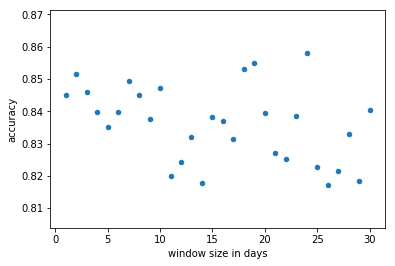

In [44]:
# Plot Accuracy vs window size
df = pd.DataFrame({"accuracy": accuracies, 
                   "window size in days":[x.days for x in window_sizes]})
df.plot(kind="scatter", y="accuracy", x="window size in days")